# Импорт библиотек

In [1]:
!pip install catboost

In [2]:
# работа с данными и таблицами
import numpy as np
import pandas as pd

# графики
import matplotlib.pyplot as plt
import seaborn as sns

# отбор признаков
from sklearn.feature_selection import mutual_info_regression, f_regression

# подготовка к обучению
from sklearn.model_selection import train_test_split

# шкалирование
from sklearn.preprocessing import MinMaxScaler

# ансамбли и модели
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
import lightgbm as lgb

# стеккинг
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor

# подбор гиперпараметров
from sklearn.model_selection import RandomizedSearchCV

# Описание функций

In [3]:
#описание функций в порядке их использования

def cols_from_chars(row):
    "Функция выделения признаков из спаршеных характеристик автомобиля"
    elements = row['chars']
    for elem in elements:
        for col in cols:
            if col in elem:
                row[col] = elem
    return row

def save_numbers(value):
    "Функция сохранения чисел из строковых признаков"
    value = str(value).strip(' ')
    number = ''
    k = 0
    for i in value:
        if i in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.']:
            k += 1
            number = number + i
        else:
            if k > 0:
                return float(number)
    if number == '':
        return np.NaN
    return float(number)

def model_from_url(row):
    "Функция сохранения модели из ссылки на автомобиль"
    brand = row.brand
    start = row.car_url.find(brand + '/')
    end = row.car_url.find('/', (start + len(brand) + 1))
    row['model'] = row.car_url[(start + len(brand) + 1):end]
    return row

def save_strings(value):
    "Функция преобразования строк в нижний регистр"
    return value.str.strip(' ').str.lower()

def boxplots (df, cols, target):
    "Функция вывода боксплота признака с разделением по целевой переменной"
    for col in cols:
        plt.figure(figsize=(12, 8))
        sns.boxplot(x = col, y = target, data = df)
        plt.show()

def hists(df, cols):
  "Функция вывода распределения признака с логарифмированной сетке"
  for col in cols:
    print (col)
    df[col].hist(bins = np.round(df[col].nunique()), width = abs(df[col].max() - df[col].min()) / df[col].nunique())
    plt.yscale('log')
    plt.show()

def hist_log_compare (df, cols):
  "Функция вывода распредения признака и распределения логарифмированного признака на логарифмированной сетке"
  for col in cols:       
        
        fig, axs = plt.subplots(1, 2, figsize=(25, 5))

        if df[col].nunique() > 100:
            n_bins = 100
        else:
            n_bins = df[col].nunique()

        width_1 = abs(df[col].max() - df[col].min()) / 100
        width_2 = abs(np.log(df[col]+1).max() - np.log(df[col]+1).min()) / 100

        axs[0].hist(df[col], bins = n_bins, width=width_1)
        title_0 = 'Базовое распределение '+col
        axs[0].set_title(title_0)
        axs[0].set_yscale('log')
        
        axs[1].hist(np.log(df[col]+1), bins = n_bins, width=width_2)
        title_1 = 'Логарифмированное распределение '+col
        axs[1].set_yscale('log')
        axs[1].set_title(title_1)

        plt.show()
        print ()

def print_barhs_reg_median (df, cols, target):
    "Функция вывода вертикальных столбцов со значениями Value_counts, Information Value, Shift of target, Weight of Evidence"
    avr_target = df[target].median()

    for col in cols:
        print()
        print (col)
        print()
        x = (df.groupby(col).median()[target] - avr_target).sort_index().index.to_list()
        y1 = df[col].value_counts().sort_index().values
        y2 = ((df.groupby(col).median()[target] - avr_target) * df[col].value_counts() / df.shape[0]).sort_index().values
        y3 = (df.groupby(col).median()[target] - avr_target).sort_index().values
        
        fig, axs = plt.subplots(1, 3, figsize=(21, 5))

        axs[0].barh(x, y1, height=0.5)
        axs[0].set_title('Value_counts')
        axs[1].barh(x, y2, height=0.5)
        axs[1].set_title('counts * median comparing with general median')
        axs[2].barh(x, y3, height=0.5)
        axs[2].set_title('median comparing with general median')

        plt.show()
        print()

def compare_medians (df, col, target):
    "Функция подсчёта медианной разности стоимости автомобилей с учётом их количества на рынке"
    avr_target = df[target].median()
    return ((df.groupby(col).median()[target] - avr_target) * df[col].value_counts() / df.shape[0]).sort_values(ascending = False).copy()

def less_than_p (df, col, p):
    "Функция поиска уникальных значений с долей менее p"
    df = df.copy()
    vc = df[col].value_counts()
    return (vc / vc.sum())[ vc / vc.sum() < p]

def order_values_median (df, cols, target):
    "Функция сортировки значений признака по величине Mean shift of target"
    temp = df.copy()
    for col in cols:        
        values = (temp.groupby(col).median()[target] - temp[target].median())
        values = values.fillna(0).sort_values().index
        for i in range(len(values)):
            temp.loc[df[col] == values[i], col] = i
    df[cols] = temp[cols].astype(float).copy()
    return df

def col_by_bins(df, cols, p):
    "Функция разделения непрерывных или дискретных признаков на корзины с количеством значений не менее доли p"
    bins_cols = []
    for col in cols:
        bins_cols.append(col + '_bins'+ str(p))

        bin_data = df[col].value_counts().sort_index()
        bin_data.index = range(len(bin_data))

        i = -1
        while i < len(bin_data)-1:
            i += 1 
            while (bin_data[i] < (p * df.shape[0])) and (i < len(bin_data)-1):
                bin_data.iloc[i] = bin_data[i] + bin_data[i + 1]
                bin_data.drop(index = i+1, axis = 0, inplace = True)
                bin_data.index = range(len(bin_data))
            

        if bin_data[i] < (p * df.shape[0]):
            bin_data.iloc[i-1] = bin_data[i-1] + bin_data[i]
            bin_data.drop(index = i, axis = 0, inplace = True)
            bin_data.index = range(len(bin_data))         

        a = (bin_data/df.shape[0]).values.tolist()
        a.insert(0, 0)
        for i in range(1,len(a)):
            a[i] = a[i]+a[i-1]
        a[-1] = 1   

        df[col + '_bins'+ str(p)] = pd.qcut(df[col],
                                      q=a,
                                      labels = range(len(a)-1), 
                                      precision = 3)
    
    df[bins_cols] = df[bins_cols].astype(float)    
    return df, bins_cols

def col_by_bins_fillna_median(df, cols, p):
    "Функция разделения непрерывных или дискретных признаков на корзины с количеством значений не менее доли p"
    "Пропуски заменяются на медиану"
    temp = df.copy()
    for col in cols:
        temp[col].fillna(temp[col].median(), inplace = True)
    
    bins_cols = []
    for col in cols:
        bins_cols.append(col + '_bins'+ str(p))

        bin_data = temp[col].value_counts().sort_index()
        bin_data.index = range(len(bin_data))
        
        i = -1
        while i < len(bin_data)-1:
            i += 1 
            while (bin_data[i] <= (p * temp.shape[0])) and (i < len(bin_data)-1):
                
                
                bin_data.iloc[i] = bin_data[i] + bin_data[i + 1]
                bin_data.drop(index = i+1, axis = 0, inplace = True)
                bin_data.index = range(len(bin_data))

            

        if bin_data[i] < (p * temp.shape[0]):
            bin_data.iloc[i-1] = bin_data[i-1] + bin_data[i]
            bin_data.drop(index = i, axis = 0, inplace = True)
            bin_data.index = range(len(bin_data))

        a = (bin_data/temp[col].shape[0]).values.tolist()
        a.insert(0, 0)
        for i in range(1,len(a)):
            a[i] = a[i]+a[i-1]
        a = list(np.array(a) / a[-1])

        df[col + '_bins'+ str(p)] = pd.qcut(temp[col],
                                          q=a,
                                          labels = range(len(a)-1), 
                                          precision = 3)
    return df, bins_cols

def fillna_by_feat_mode (df, nans_feat, help_feat):
    "Функция заполнения признака с помощью медианы указанного признака"
    nan_mask = df[nans_feat].isna() == True
    bins = df.loc[nan_mask, help_feat].unique()
    for bin in bins:
      bin_mask = df[help_feat] == bin
      value = df.loc[bin_mask, nans_feat].mode()[0]
      df.loc[nan_mask & bin_mask, nans_feat] = value

def cat_feat_imp_reg (df, cols, target):
    "Функция определения важности категориальных признаков"
    imp_cat = pd.Series(mutual_info_regression(df.loc[df[target].isna() == False, cols], df.loc[df[target].isna() == False, target],
                                        discrete_features =True), index = cols)
    return imp_cat.sort_values()

def cat_features_importants_reg (df, features, target):
    "Функция формирования дата фрейма для бинарных признаков, который содержит:"
    "важность признака, корреляцию c целевой переменной,"
    "максимальную корреляцию с другими переменными"
    cat_importance = cat_feat_imp_reg (df, features, target)

    feature_select = pd.DataFrame(index = features)

    df_out = df[df[target].isna() == False].copy()

    corr_table = df_out[features].corr()

    for col in features:
        feature_select.loc[col, 'importance'] = cat_importance[col]
        feature_select.loc[col, 'target_corr'] = df_out[[target] + [col]].corr()[target].min()
        feature_select.loc[col, 'feat_max_corr'] = corr_table[col].sort_values(ascending = False).iloc[1]
        feature_select.loc[col, 'feat_name'] = corr_table[col].sort_values(ascending = False).index[1]
          
    return feature_select.sort_values(by = 'importance', ascending=False)

def num_feat_imp_reg(df, cols, target): 
    "Функция определения важности численных признаков"
    imp_num = pd.Series(f_regression (df.loc[df[target].isna() == False, cols], df.loc[df[target].isna() == False, target])[0], index = cols)
    return imp_num.sort_values()

def num_features_importants_reg (df, features, target):
    "Функция формирования дата фрейма для числовых и ординальных признаков, который содержит:"
    "важность признака, корреляцию c целевой переменной,"
    "максимальную корреляцию с другими переменными"
    cat_importance = num_feat_imp_reg (df, features, target)

    feature_select = pd.DataFrame(index = features)

    df_out = df[df[target].isna() == False].copy()

    corr_table = df_out[features].corr()

    for col in features:
             
        feature_select.loc[col, 'importance'] = cat_importance[col]
        feature_select.loc[col, 'target_corr'] = df_out[[target] + [col]].corr()[target].min()
        feature_select.loc[col, 'feat_max_corr'] = corr_table[col].sort_values(ascending = False).iloc[1]
        feature_select.loc[col, 'feat_name'] = corr_table[col].sort_values(ascending = False).index[1]
          
    return feature_select.sort_values(by = 'importance', ascending=False)

def mape(y_true, y_pred):
    "Функция расчёта метрики MAPE"
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Data

## Test data

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
test = pd.read_csv('/content/drive/MyDrive/module_7/test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [7]:
test.nunique()

bodyType                   24
brand                      12
car_url                 34686
color                      16
complectation_dict       2364
description             31732
engineDisplacement         55
enginePower               315
equipment_dict          23705
fuelType                    5
image                   34557
mileage                 11268
modelDate                  66
model_info                954
model_name                544
name                     2780
numberOfDoors               5
parsing_unixtime        34686
priceCurrency               1
productionDate             69
sell_id                 34686
super_gen                5890
vehicleConfiguration      634
vehicleTransmission         4
vendor                      2
Владельцы                   3
Владение                  275
ПТС                         2
Привод                      3
Руль                        2
Состояние                   1
Таможня                     1
dtype: int64

Будем парсить только бренды присутствующие в тесте. Посмотрим на них.

In [8]:
brands = test.brand.unique()
brands

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

In [9]:
test.productionDate.value_counts(ascending = False)

2012    2798
2008    2606
2011    2589
2013    2488
2014    2134
        ... 
1904       1
1936       1
1968       1
1939       1
1948       1
Name: productionDate, Length: 69, dtype: int64

productionDate


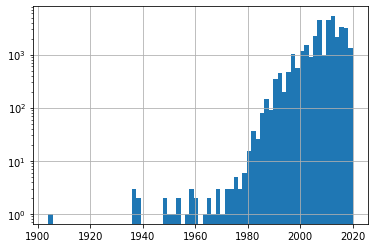

In [10]:
hists(test, ['productionDate'])

In [11]:
test[test.productionDate < 1980]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
771,седан,SKODA,https://auto.ru/cars/used/sale/skoda/100_serie...,белый,NaN,Цена без документов 76000р.\n\nНа автомобиль п...,1.0 LTR,42 N12,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,74969,1969,"{""code"":""100_SERIES"",""name"":""100 Series"",""ru_n...",100_SERIES,100 1.0 MT (42 л.с.),4,1603229210,RUB,1976,1096411742,"{""id"":""20474326"",""nameplate"":""100"",""displaceme...",SEDAN MECHANICAL 1.0,механическая,EUROPEAN,1 владелец,28 лет и 8 месяцев,Оригинал,задний,Левый,Не требует ремонта,Растаможен
1777,хэтчбек 3 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/popular/1...,чёрный,NaN,"Авто после длительного простоя, под восстановл...",1.1 LTR,30 N12,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,14000,1934,"{""code"":""POPULAR"",""name"":""Popular"",""ru_name"":""...",POPULAR,1.1 MT (30 л.с.),3,1603232963,RUB,1939,1097046168,"{""id"":""20783514"",""displacement"":1089,""engine_t...",HATCHBACK_3_DOORS MECHANICAL 1.1,механическая,EUROPEAN,3 или более,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
3174,седан,AUDI,https://auto.ru/cars/used/sale/audi/920/109152...,чёрный,NaN,"Ауди кабриолет, 1938 г., ретро, на ходу, есть ...",3.3 LTR,75 N12,NaN,бензин,https://autoru.naydex.net/ys1kR7800/fbd964zfcB...,90000,1938,"{""code"":""920"",""name"":""920"",""ru_name"":""920"",""mo...",920,3.3 MT (75 л.с.),4,1603124719,RUB,1938,1091525266,"{""id"":""20652212"",""displacement"":3281,""engine_t...",SEDAN MECHANICAL 3.3,механическая,EUROPEAN,2 владельца,34 года и 2 месяца,Оригинал,задний,Левый,Не требует ремонта,Растаможен
6568,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/240_serie...,голубой,NaN,Комплект зимних шин Б / У в подарок Непроку...,2.0 LTR,90 N12,"{""driver-seat-updown"":true,""tinted-glass"":true...",бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,1000000,1974,"{""code"":""240_SERIES"",""name"":""240 Series"",""ru_n...",240_SERIES,2.0 MT (90 л.с.),4,1603236533,RUB,1978,1099397220,"{""id"":""21279670"",""displacement"":1998,""engine_t...",SEDAN MECHANICAL 2.0,механическая,EUROPEAN,3 или более,2 года и 3 месяца,Оригинал,задний,Левый,Не требует ремонта,Растаможен
7216,седан 2 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/140/10985...,белый,NaN,Элементы экстерьера: 1.,2.0 LTR,82 N12,"{""14-inch-wheels"":true}",бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,150000,1966,"{""code"":""140"",""name"":""140 Series"",""ru_name"":""1...",140,2.0 MT (82 л.с.),2,1603238929,RUB,1970,1098529726,"{""id"":""20475379"",""displacement"":2000,""engine_t...",SEDAN_2_DOORS MECHANICAL 2.0,механическая,EUROPEAN,2 владельца,5 лет и 7 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен
7256,универсал 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/240_serie...,пурпурный,NaN,Куплен в Голландии.\nКузов в родной краске.\nО...,2.1 LTR,122 N12,"{""engine-proof"":true,""passenger-seat-updown"":t...",бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,240000,1974,"{""code"":""240_SERIES"",""name"":""240 Series"",""ru_n...",240_SERIES,2.1 MT (122 л.с.),5,1603239084,RUB,1979,1092377190,"{""id"":""20481628"",""displacement"":2127,""engine_t...",WAGON_5_DOORS MECHANICAL 2.1,механическая,EUROPEAN,2 владельца,29 лет и 11 месяцев,Оригинал,задний,Левый,Не требует ремонта,Растаможен
7774,седан,BMW,https://auto.ru/cars/used/sale/bmw/5er/1090506...,красный,NaN,Подробности по телефону,2.0 LTR,109 N12,NaN,бензин,https://autoru.naydex.net/lICN99c69/9bc7d3Rr7k...,145000,1976,"{""code"":""5ER"",""name"":""5 серии"",""ru_name"":""5 се...",5ER,518 2.0 MT (109 л.с.),4,1603108509,RUB,1977,1090506492,"{""id"":""20389900"",""name"":""518"",""nameplate"":""518...",SEDA

In [12]:
test[test.productionDate < 1980].brand.value_counts()

MERCEDES      22
BMW           10
VOLKSWAGEN     5
VOLVO          3
SKODA          2
TOYOTA         2
AUDI           1
NISSAN         1
Name: brand, dtype: int64

In [13]:
now_year = 2022
prodDates = range(test.productionDate.min()-5,  now_year+1)
prodDates

range(1899, 2023)

## Train data. Parsing

Данные были собраны параллельно в локальном ноутбуке. Ниже представлен код парсинга с комментариями. Так как собрать ссылки с помощью requests не получилось из-за устройства сайта auto.ru, то их собирал с помощью selenium. Характеристики автомобиля собирал с помошью requests, т.к. это быстрее. 

In [ ]:
# будем собирать ссылки на автомобили в таблицу
cars = pd.DataFrame(columns = ['name', 'url', 'brand'])

#запускаем вебдрайвер
driver = webdriver.Chrome(executable_path=r'C:\chromedriver\chromedriver.exe')
time.sleep(2)

#парсить ссылку будем по брендам, которые предварительно отобрали
for brand in brands:
    brand_low = brand.lower()
    #будем перелистывать страницы с первой по 30
    for i in range(1, 31):
        #открываем страницу
        driver.get('https://auto.ru/moskva/cars/' + brand_low + '/all/?page='+str(i))
        
        #ждем пока страница прогрузится
        time.sleep(10)

        #собираем информацию и преобразуем в нужный нам формат с помошью BeautifulSoup
        page = driver.execute_script('return document.body.innerHTML;')
        soup = BeautifulSoup(page, 'html.parser')

        # по тэгам и классу ищем нужные ссылки и помещаем их в нашу таблицу
        cars_list = soup.find_all('a', class_ = "Link ListingItemTitle__link")
        for elem in cars_list:
            car = { 'name' : elem.text, 'url' : elem.get('href'), 'brand' : brand_low}
            cars = pd.concat([cars, pd.DataFrame([car])], ignore_index = True)
driver.quit()

In [14]:
cars = pd.read_csv('cars_url.csv')
# дополнительно собрали немного информации по старым машинам
old_cars = pd.read_csv('Old_cars_url.csv')
cars = pd.concat([cars, old_cars], axis = 0)

In [ ]:
cars.sample(5)

,name,url,brand
7392,Mercedes-Benz M-Класс AMG 55 AMG I (W163) Рест...,https://auto.ru/cars/used/sale/mercedes/m_klas...,mercedes
10200,Lexus ES 350 V Рестайлинг,https://auto.ru/cars/used/sale/lexus/es/110657...,lexus
10262,Lexus GS 300 III Рестайлинг,https://auto.ru/cars/used/sale/lexus/gs/110613...,lexus
10102,Lexus RX 300 I,https://auto.ru/cars/used/sale/lexus/rx/110623...,lexus
9399,Lexus NX 200 I Рестайлинг,https://auto.ru/cars/used/sale/lexus/nx/110665...,lexus


In [ ]:
cars.shape

(12657, 3)

In [ ]:
train = pd.DataFrame(['chars','price','url','brand'])

#переходим по сcылкам и забираем нужную информацию с помощью requests
for i in cars.index:
    url = cars['url'][i]
    
    req = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})   
    req.encoding = 'utf-8'

    #делаем остановку, чтобы не преувеличить количество запросов в секунду
    time.sleep(0.5)

    #преобразуем в нужный нам формат с помошью BeautifulSoup
    soup = BeautifulSoup(req.text, 'html.parser')  
     
    #так как на разных ссылках могут быть установлены разные классы для нужной информации, то
    #будем забирать информацию, если она соотвествует одному из трех классов
    if soup.find('ul', class_ = 'CardInfoGrouped__list') is None:
        if soup.find('ul', class_ = 'CardInfoGrouped') is None:
            if soup.find('ul', class_ = 'CardInfo') is None:
                continue
            else:
                
                #забираем характеристики по тегу и классу, убираем лишнию символы
                chars = [child.get_text(' ').replace('\xa0', '') for child in soup.find('ul', class_ = 'CardInfo').children]
        else:
            chars = [child.get_text(' ').replace('\xa0', '') for child in soup.find('ul', class_ = 'CardInfoGrouped').children]
    else:
        chars = [child.get_text(' ').replace('\xa0', '') for child in soup.find('ul', class_ = 'CardInfoGrouped__list').children]
                
    #забираем цену автомобиля по тегу и классу
    if soup.find('span', class_ = 'OfferPriceCaption__price') is None: 
        continue
    else:  
        price = soup.find('span', class_ = 'OfferPriceCaption__price').text.replace('\xa0', '')

    #формируем новую строчку
    car = { 'chars' : chars,
            'price' : price, 
            'url' : url,
            'brand' : cars['brand'][i]}


    #добавляем строчку в дата фрейм       
    train = pd.concat([train, pd.DataFrame([car])], ignore_index = True)

In [15]:
train = pd.read_csv('All_cars.csv')
old_cars = pd.read_csv('Old_cars.csv')
train = pd.concat([train, old_cars], ignore_index = True)
train['parsing_year'] = 2022
train.sample(3)

,url,price,chars,brand,parsing_year
1675,https://auto.ru/cars/used/sale/audi/a4/1106523...,5450000₽,"['год выпуска 2020', 'Пробег 9000км', 'Кузов с...",audi,2022
8021,https://auto.ru/cars/used/sale/toyota/rav_4/11...,440000₽,"['год выпуска 1999', 'Пробег 402000км', 'Кузов...",toyota,2022
5191,https://auto.ru/cars/used/sale/nissan/x_trail/...,1620000₽,"['год выпуска 2017', 'Пробег 217000км', 'Кузов...",nissan,2022


In [16]:
train.shape

(12052, 5)

Забегая вперёд скажу, что на данных, которые мы спарсили, получилось добиться скора в 0.18 на лидерборде. Добавим новые данные. Я взял их из работ студентов и бейслайна. Таким образом отработаем повышение эффективности моделей на больших объёмах данных.

In [17]:
#train - 2022
train_2020 = pd.read_csv('/content/drive/MyDrive/module_7/all_auto_ru_09_09_2020.csv')
train_2021 = pd.read_csv('/content/drive/MyDrive/module_7/train_df_full_part1.csv')

In [18]:
train_2020['parsing_year'] = 2020
train_2020.sample(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model,parsing_year
30220,Седан,HYUNDAI,FAFBFB,бензин,2019.0,2.0 AT (150 л.с.),4.0,2020,SEDAN AUTOMATIC 2.0,AUTOMATIC,2.0,150.0,ФИНАЛЬНАЯ ПРОДАЖА АВТОМОБИЛЕЙ HYUNDAI!\nСНИЖЕН...,0,"{'id': '21783276', 'name': 'Comfort', 'availab...",передний,LEFT,NaN,NaN,ORIGINAL,True,NaN,1659000.0,2020-06-19T21:26:17Z,NaN,SONATA,2020
62194,Лифтбек,SKODA,FAFBFB,бензин,2017.0,1.6 MT (90 л.с.),5.0,2019,LIFTBACK MECHANICAL 1.6,MECHANICAL,1.6,90.0,Автомобиль ПРОШЕЛ ПРОВЕРКУ 100%-ной юридическо...,13581,"{'id': '21515364', 'name': 'Hockey Edition Act...",передний,LEFT,NaN,1.0,ORIGINAL,True,NaN,850000.0,2020-09-01T14:45:14Z,NaN,RAPID,2020
73232,Седан,VOLKSWAGEN,FAFBFB,бензин,2014.0,1.6 AT (110 л.с.),4.0,2018,SEDAN AUTOMATIC 1.6,AUTOMATIC,1.6,110.0,Автомобиль представлен MAJOR EXPERT – крупнейш...,45413,{'id': '0'},передний,LEFT,NaN,1.0,ORIGINAL,True,NaN,615000.0,2020-07-20T13:21:40Z,NaN,POLO,2020


In [19]:
train_2020.shape

(89378, 27)

In [20]:
train_2021['parsing_year'] = 2021
train_2021.sample(3)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,views,date_added,region,price,parsing_year
39843,внедорожник 5 дв.,BMW,https://auto.ru/cars/new/group/bmw/x3/21029738...,белый,"['cruise-control', 'sport-seats', 'multi-wheel...",Комплектация xDrive20d M Sport При покупке авт...,2.0 LTR,190 N12,"{'audiosystem-cd': True, 'airbag-side': True, ...",дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,NaN,2017.0,NaN,NaN,BMW X3 20d xDrive III (G01),5.0,1.632742e+09,RUB,2021.0,1.104787e+09,"{'sale-data-attributes': {'asciiCat': 'cars', ...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
61299,внедорожник 5 дв.,MERCEDES,https://auto.ru/cars/used/sale/mercedes/gls_kl...,чёрный,"['cruise-control', 'multi-wheel', 'auto-park',...",Ваш выбор и Ваше время наши главные приоритет...,3.0 LTR,249 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",дизель,https://autoru.naydex.net/t17i2re75/c22f412D/h...,62430.0,2015.0,NaN,GLS,Mercedes-Benz GLS 350 d I (X166),5.0,1.632798e+09,RUB,2018.0,1.104829e+09,"{'sale-data-attributes': {'asciiCat': 'cars', ...",ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,NaN,3 или более,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,162.0,27 сентября,в Москве,4599000.0,2021
36778,седан,BMW,https://auto.ru/cars/used/sale/bmw/2er/1105299...,белый,"['cruise-control', 'sport-seats', 'multi-wheel...",Ваш выбор и Ваше время наши главные приоритеты...,1.5 LTR,140 N12,"{'tinted-glass': True, 'esp': True, 'adaptive-...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,8000.0,2019.0,NaN,2 серии,BMW 2 серии Gran Coupe 218i F44,4.0,1.632735e+09,RUB,2020.0,1.105300e+09,"{'sale-data-attributes': {'asciiCat': 'cars', ...",SEDAN ROBOT 1.5,роботизированная,NaN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,526.0,25 сентября,в Москве,2460000.0,2021


In [21]:
train_2021.region.value_counts().head(10)

 в Москве              39180
 в Санкт-Петербурге    14011
 в Ростове-на-Дону      5252
 в Краснодаре           4698
 в Тюмени               2451
 в Красноярске          2146
 в Екатеринбурге        1853
 в Волгограде           1795
 в Самаре               1594
 в Новосибирске         1334
Name: region, dtype: int64

## Объединение train и test: преобразование и очистка данных

Обработаем данные: выделим признаки из колонки chars и найдем совподающие с test, объеденим дата фреймы и удалим лишнюю информацию. Поработаем со значениями, чтобы получить релевантную информацию. Воспользуемся подготовленными функциями.

In [22]:
train.loc[(train.chars.map(type) == str), 'chars'] = train[(train.chars.map(type) == str)].chars.str.strip('[').str.strip(']').str.split(',')

In [23]:
cols = ['год выпуска', 'Пробег', 'Кузов', 'Цвет', 'Двигатель', 
           'Комплектация', 'Запас хода', 'Налог', 'Коробка', 'Привод', 
           'Руль', 'Состояние', 'Владельцы', 'ПТС', 'Владение',
          'Таможня', 'Гарантия', 'Обмен']

In [24]:
train = train.apply(cols_from_chars, axis = 1)
train.drop('chars', axis = 1, inplace = True)
train.sample(3)

,brand,parsing_year,price,url,Владельцы,Владение,Гарантия,Двигатель,Запас хода,Комплектация,Коробка,Кузов,Налог,Обмен,ПТС,Привод,Пробег,Руль,Состояние,Таможня,Цвет,год выпуска
5829,nissan,2022,150000₽,https://auto.ru/cars/used/sale/nissan/almera/1...,'Владельцы 3 или более','Владение 2 года и 3 месяца',NaN,'Двигатель 1.4 л / 75л.с. / Бензин',NaN,NaN,'Коробка механическая','Кузов седан','Налог 900₽ / год',NaN,'ПТС Оригинал','Привод передний','Пробег 265000км','Руль Левый','Состояние Не требует ремонта','Таможня Растаможен','Цвет зелёный','год выпуска 1996'
5034,nissan,2022,1160000₽,https://auto.ru/cars/used/sale/nissan/terrano/...,'Владельцы 1владелец',NaN,NaN,'Двигатель 2.0 л / 143л.с. / Бензин',NaN,'Комплектация Elegance Plus','Коробка механическая','Кузов внедорожник 5 дв.','Налог 5005₽ / год','Обмен Рассмотрю варианты','ПТС Оригинал','Привод полный','Пробег 89000км','Руль Левый','Состояние Не требует ремонта','Таможня Растаможен','Цвет белый','год выпуска 2016'
1995,honda,2022,1300000₽,https://auto.ru/cars/used/sale/honda/cr_v/1106...,'Владельцы 1владелец',NaN,'Гарантия До января 2024','Двигатель 2.0 л / 150л.с. / Бензин',NaN,'Комплектация 27опций','Коробка механическая','Кузов внедорожник 5 дв.','Налог 5250₽ / год','Обмен Рассмотрю варианты','ПТС Оригинал','Привод передний','Пробег 139000км','Руль Левый','Состояние Не требует ремонта','Таможня Растаможен','Цвет серый','год выпуска 2007'


In [25]:
for col in cols:
    train[col] = train[col].str.strip(' ').str.strip("'").str.strip(col)

In [27]:
train['Двигатель'] = train['Двигатель'].str.split(' / ')
#сразу переименуем часть признаков в название для объединения
for i in train['Двигатель'].dropna().index:
    elements = train.loc[i, 'Двигатель']
    if len(elements) == 3:
        train.loc[i, 'engineDisplacement'] = elements[0]
        train.loc[i, 'enginePower'] = elements[1]
        train.loc[i, 'fuelType'] = elements[2]

    elif len(elements) == 2:
        train.loc[i, 'engineDisplacement'] = elements[0]
        train.loc[i, 'fuelType'] = elements[1]

Забегая вперёд - во время анализа обнаружилось, что в в колонку 'engineDisplacement' (объём двигателя), попали значения мощности двигателя. А в колонку мощность двигателя попала мощность в другой системе измерения. Мы будем записывать мощность в лошадиных силах. Преобразуем их на данном этапе, пока мы не избавились от лишних данных, в которые мы можем подсмотреть сейчас.

In [28]:
train['engineDisplacement'] = train['engineDisplacement'].apply(save_numbers)

In [29]:
train[train['engineDisplacement'] > 12][['engineDisplacement',	'enginePower']]

,engineDisplacement,enginePower
817,170.0,125кВт
854,170.0,125кВт
941,408.0,300кВт
963,408.0,300кВт
966,408.0,300кВт
991,408.0,300кВт
1001,408.0,300кВт
1006,408.0,300кВт
1031,408.0,300кВт
1040,408.0,300кВт


In [30]:
train.loc[train['engineDisplacement'] > 12, 'enginePower'] = train.loc[train['engineDisplacement'] > 12, 'engineDisplacement']
# заменим неправильный объём на пустые значения
train.loc[train.engineDisplacement > 12, 'engineDisplacement'] = np.NaN

In [31]:
train_2020['engineDisplacement'] = train_2020['engineDisplacement'].apply(save_numbers)

In [32]:
train_2020[train_2020['engineDisplacement'] > 12][['engineDisplacement',	'enginePower', 'name']]

,engineDisplacement,enginePower,name
695,16.0,140.0,16V 2.0d MT (140 л.с.)
875,16.0,140.0,16V 2.0d MT (140 л.с.)
902,16.0,140.0,16V 2.0d CVT (140 л.с.)
927,16.0,140.0,16V 2.0d CVT (140 л.с.)
1202,16.0,140.0,16V 2.0d CVT (140 л.с.)
...,...,...,...
88647,200.0,122.0,200 2.0 MT (122 л.с.)
88648,230.0,132.0,230 2.3 AT (132 л.с.)
88658,350.0,258.0,350 d 3.0d AT (258 л.с.) 4WD
88659,250.0,190.0,250 d 2.3d AT (190 л.с.) 4WD


In [33]:
fix_engine = train_2020[train_2020['engineDisplacement'] > 12][['engineDisplacement',	'enginePower', 'name']].copy()
fix_index = fix_engine.index

In [34]:
#избавимся от первых символов, которыми по видимому и заполнили неправильно объём двигателя и возьмём следующие значения с объёмом двигателя
fix_engine['name_2'] = fix_engine.apply(lambda row: str(row['name']).replace(str(int(row['engineDisplacement'])), ''), axis = 1)
fix_engine['engineDisplacement'] = fix_engine['name_2'].astype(str).apply(save_numbers)
#str.replace(fix_engine['engineDisplacement'].astype(str), ''))

In [35]:
fix_engine.sample(5)

,engineDisplacement,enginePower,name,name_2
82120,3.0,333.0,400 3.0 AT (333 л.с.) 4WD,3.0 AT (333 л.с.) 4WD
6489,3.0,272.0,530i 3.0 AT (272 л.с.),i 3.0 AT (272 л.с.)
5934,2.0,184.0,520i 2.0 AT (184 л.с.),i 2.0 AT (184 л.с.)
6671,2.0,190.0,520d xDrive 2.0d AT (190 л.с.) 4WD,d xDrive 2.0d AT (190 л.с.) 4WD
87983,4.0,612.0,63 AMG Long 4.0 AT (612 л.с.) 4WD,AMG Long 4.0 AT (612 л.с.) 4WD


In [36]:
fix_engine[fix_engine.engineDisplacement > 12]

,engineDisplacement,enginePower,name,name_2
2851,301.0,408.0,55 Electro AT (301 кВт) 4WD,Electro AT (301 кВт) 4WD
2852,301.0,408.0,55 Electro AT (301 кВт) 4WD,Electro AT (301 кВт) 4WD
2853,301.0,408.0,55 Electro AT (301 кВт) 4WD,Electro AT (301 кВт) 4WD
2854,301.0,408.0,55 Electro AT (301 кВт) 4WD,Electro AT (301 кВт) 4WD
2855,301.0,408.0,55 Electro AT (301 кВт) 4WD,Electro AT (301 кВт) 4WD
2856,301.0,408.0,55 Electro AT (301 кВт) 4WD,Electro AT (301 кВт) 4WD
2857,301.0,408.0,55 Electro AT (301 кВт) 4WD,Electro AT (301 кВт) 4WD
2858,301.0,408.0,55 Electro AT (301 кВт) 4WD,Electro AT (301 кВт) 4WD
2859,301.0,408.0,55 Electro AT (301 кВт) 4WD,Electro AT (301 кВт) 4WD
2860,301.0,408.0,55 Electro AT (301 кВт) 4WD,Electro AT (301 кВт) 4WD


In [37]:
# заполним несколько двигателей в ручную, остальное заполним пропусками
fix_engine.loc[5634] = 1.8
fix_engine.loc[[81715, 81731]] = 6.2
fix_engine.loc[fix_engine.engineDisplacement > 12, 'engineDisplacement'] = np.NaN

In [38]:
train_2020.loc[fix_index, 'engineDisplacement'] = fix_engine['engineDisplacement']

In [39]:
train.drop('Двигатель', axis = 1, inplace = True)

In [40]:
# переименуем признаки
name_columns = { 'Цвет' : 'color', 
                'Комплектация' : 'complectation_dict',
                'год выпуска' : 'productionDate',
                'Пробег' : 'mileage',
                'Кузов' : 'bodyType',
                'Коробка' : 'vehicleTransmission',
                'url' : 'car_url'
                }

train.rename(columns = name_columns, inplace = True)

In [41]:
train['test'] = 0
train_2021['test'] = 0
train_2020['test'] = 0
test['test'] = 1
test['parsing_year'] = 2020

In [42]:
#объеденим обучающие выборки
df = pd.concat ([train, train_2021, train_2020, test], ignore_index = True)
df.shape

(266317, 46)

Выберем колонки под удаление.
Найдём полностью пустые признаки в тесте.

In [43]:
# заполним регион в тесте на Москву
df.loc[df['test'] == 1, 'region'] = df.region.mode()[0]

In [44]:
# признаки без значений на тесте
df[df['test'] == 1].nunique()[df[df['test'] == 1].nunique() == 0]

price           0
Гарантия        0
Запас хода      0
Налог           0
Обмен           0
views           0
date_added      0
Комплектация    0
start_date      0
hidden          0
model           0
dtype: int64

In [45]:
# заполним признак модель, 
# во время парсинга заметил, что в ссылке содержится название модели
df[['model', 'car_url']].sample(5)

,model,car_url
102616,NaN,https://auto.ru/cars/used/sale/toyota/tundra/1...
119740,NaN,https://auto.ru/cars/used/sale/volkswagen/polo...
72770,NaN,https://auto.ru/cars/used/sale/mercedes/amg_gt...
66266,NaN,https://auto.ru/cars/used/sale/nissan/terrano/...
4886,NaN,https://auto.ru/cars/new/group/nissan/x_trail/...


In [46]:
# выделим недостающие модели из ссылки, перед этим переведём все названия в нижний регистр
df['brand'] = df['brand'].str.lower()
df['model'] = df['model'].str.lower()
df[df.car_url.isna() == False] = df[df.car_url.isna() == False].apply(model_from_url, axis = 1)

In [47]:
df['description'] = df.description.str.len()

In [48]:
#очистим числовые значения от различных сокращений метрических единиц и оставит только цифры в признаках
num_cols = ['engineDisplacement', 'enginePower', 'productionDate', 'mileage', 'Владельцы', 'price', 'numberOfDoors', 'modelDate','description']
for col in num_cols: 
    df[col] = df[col].apply(save_numbers)
df[num_cols].sample(3)

,engineDisplacement,enginePower,productionDate,mileage,Владельцы,price,numberOfDoors,modelDate,description
83128,5.4,507.0,2010.0,180000.0,3.0,2498000.0,5.0,2008.0,521.0
182875,2.0,147.0,2011.0,190000.0,3.0,600000.0,4.0,2009.0,621.0
140858,1.6,98.0,2006.0,107000.0,3.0,299000.0,4.0,2005.0,184.0


In [49]:
cat_cols = ['bodyType', 'model', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'ПТС', 'Привод', 'Руль', 'region']
df[cat_cols] = df[cat_cols].apply(save_strings)
df[cat_cols].sample(3)

,bodyType,model,brand,color,fuelType,vehicleTransmission,ПТС,Привод,Руль,region
128908,внедорожник 5 дв.,touareg,volkswagen,коричневый,дизель,автоматическая,оригинал,полный,левый,в москве
89609,внедорожник 5 дв.,gle_klasse_coupe,mercedes,белый,дизель,автоматическая,оригинал,полный,левый,в севастополе
125282,минивэн,multivan,volkswagen,чёрный,дизель,роботизированная,оригинал,полный,левый,в москве


In [50]:
df[df['test'] == 0].price.isna().sum()

20872

In [51]:
# после преобразований у нас имеются пустые значения в целевого признака в трейне - избавимся от этих строк 
to_drop = df[(df['price'].isna() == True) & (df['test'] == 0)].index
df.drop(to_drop, axis = 0, inplace = True)
df.index = range(len(df))

In [52]:
# окончательно переименуем часть признаков
name_columns = {'productionDate' : 'prod_date',
                'bodyType' : 'body',
                'vehicleTransmission' : 'transmission',
                'Привод' : 'drive',
                'Руль' : 'steering',
                'Владельцы' : 'owner_count',
                'ПТС' : 'passport',
                'Владение' : 'owner_duration',
                'engineDisplacement' : 'engine_volume',
                'enginePower' : 'engine_power',
                'fuelType' : 'fuel',
                'numberOfDoors' : 'num_doors'
                }

In [53]:
df.rename(columns = name_columns, inplace = True)

In [54]:
# разделим переменные на числовые и категориальные (в т.ч. ординальные)
num_cols = ['engine_volume', 'engine_power', 'prod_date', 'mileage', 'description']
cat_cols = ['body', 'model', 'brand', 'color', 'fuel', 'transmission', 'passport', 'drive', 'steering', 'owner_count', 'num_doors', 'parsing_year', 'region']

In [55]:
df = df[cat_cols + num_cols + ['price', 'test']]

In [57]:
# удалим дубли из трейна
df = pd.concat([ df[df['test'] == 0].drop_duplicates(keep = 'last'), df[df['test'] == 1] ], axis = 0, ignore_index = True)

In [58]:
df.shape

(164241, 20)

# Data Preprocessing, EDA


Для анализа признаков с точки зрения влияния не цену, нам нужно привести цену примерно в одну временную плоскость, потому что все наши данные были собраны в 2020 году. Посмотрим на то, как сильно год влияет на цену.

2022 год только начался, поэтому цены не слишком отличаются от 2021 года. Тем более выборка 2021 и 2022 года вместе взятые меньше, чем выборка из 2020 года.

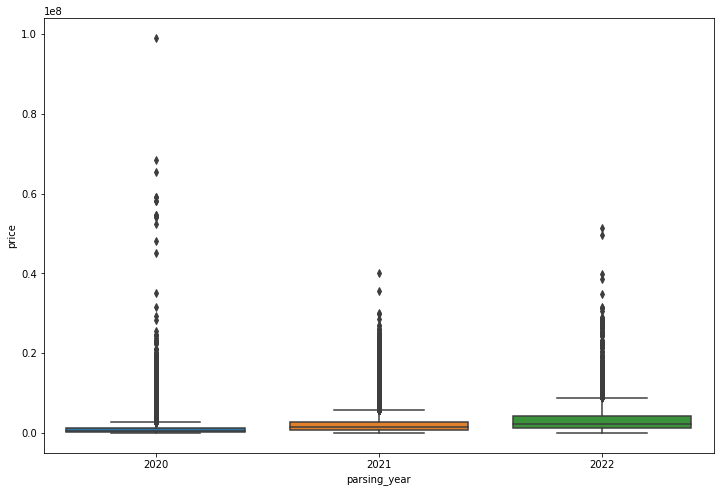

In [59]:
boxplots(df, ['parsing_year'],'price')

In [60]:
# уменьшим стоимость автомобилей 2021го и 2022го года, 
# коэффициент подобран эмпирически с учётом инфляции и курса доллара
df.loc[df['parsing_year'].isin([2021,2022]), 'price'] = df.loc[df['parsing_year'].isin([2021,2022]), 'price'] / 1.16

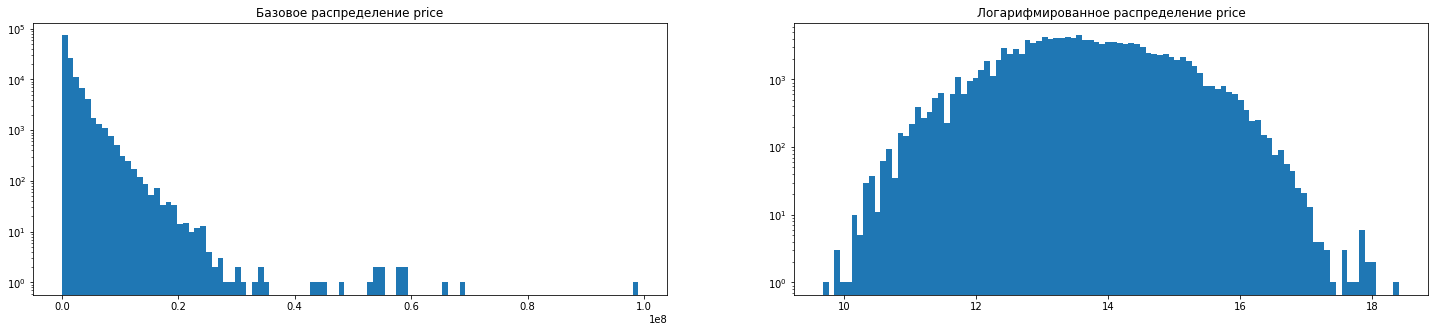

In [61]:
# Видим, по боксплотам, что цены можно логарифмировать, 
# уже из бейслайна понятно, что логарифмирование улучшает качество предсказания цены
hist_log_compare(df, ['price'])

In [62]:
# прологарифмируем
df['price'] = np.log(df['price'] + 1)

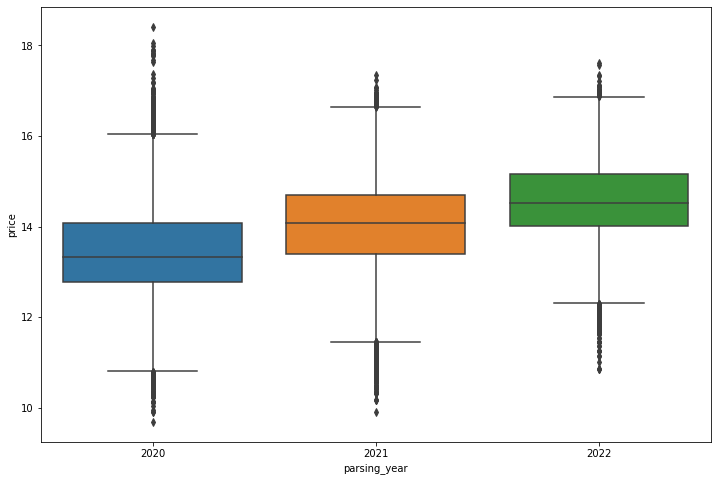

In [63]:
boxplots(df, ['parsing_year'],'price')

## Категориальные признаки

Посмотрим на количество пропущенных значений и пометим их значением isNaN для строк, и -1 для чисел.

In [64]:
df[cat_cols].isna().sum()

body                2
model               0
brand               0
color               0
fuel                1
transmission        2
passport         8861
drive            5428
steering         8513
owner_count     18309
num_doors        9321
parsing_year        0
region          99397
dtype: int64

In [65]:
for col in cat_cols:
    if df[col].dropna().apply(type).value_counts().index[0] == str :
        df[col] = df[col].fillna('isNaN')
    else:
        df[col] = df[col].fillna(-1)

In [66]:
df[cat_cols].nunique().sort_values(ascending = False)

region          1278
model           1158
body             273
brand             36
color             32
transmission      10
fuel               8
num_doors          6
passport           5
steering           5
drive              4
owner_count        4
parsing_year       3
dtype: int64

Посмотрим на количественное распределение признаков в датасете и их влияние на 'price' по сравнению со медианными значениями цен. Посмотрим на количество уникальных значений, избавимся от мусора, объеденим малое количество категорий. Сделаем промежуточные выводы по признакам.

### brand

У нас в трейне намного больше брендов, чем изначально было в тесте. 36 против 12. Но дополнительная инфомрация будет полезна.

In [68]:
df.brand.value_counts()

bmw           15646
mercedes      15601
volkswagen    14779
nissan        13456
toyota        12073
audi          11342
skoda          9566
mitsubishi     9412
volvo          7437
honda          6213
lexus          5718
hyundai        5529
kia            5445
ford           4763
infiniti       3925
chevrolet      3581
opel           3086
renault        2680
mazda          2278
peugeot        1602
land_rover     1565
citroen        1116
daewoo         1028
subaru          872
suzuki          842
ssang_yong      707
porsche         699
chery           558
jeep            456
great_wall      416
dodge           412
chrysler        316
cadillac        309
mini            303
jaguar          294
geely           216
Name: brand, dtype: int64

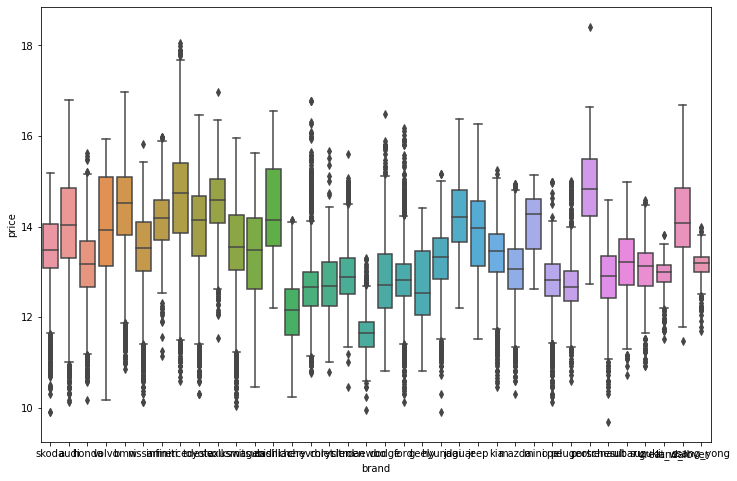

In [69]:
boxplots (df, ['brand'], 'price')

In [70]:
# видим экстремально дорогой автомобиль. посмотрим что это и убедимся, что это редкий автомобиль, который нам не подходим. Удалим
df[df.price == df.price.max()]

,body,model,brand,color,fuel,transmission,passport,drive,steering,owner_count,num_doors,parsing_year,region,engine_volume,engine_power,prod_date,mileage,description,price,test
98469,родстер,918_spyder,porsche,cacecb,гибрид,robot,original,задний,left,1.0,2.0,2020,isNaN,4.6,608.0,2015.0,5169.0,3022.0,18.41063,0


In [71]:
df.drop(df[df.price == df.price.max()].index, axis = 0, inplace = True)
df.index = range(len(df))


brand



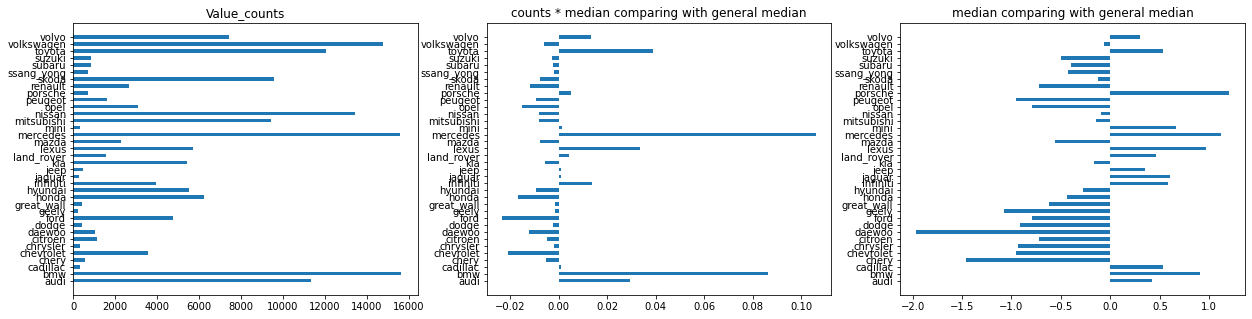

In [72]:
print_barhs_reg_median (df, ['brand'], 'price')

In [73]:
# посмотрим на самые дорогие бренды по медиане c учётом их количества на рынке
top_brands = compare_medians(df, 'brand', 'price')
exp_brands = top_brands.head(5).index.to_list()
cheap_brands = top_brands.tail(5).index.to_list()

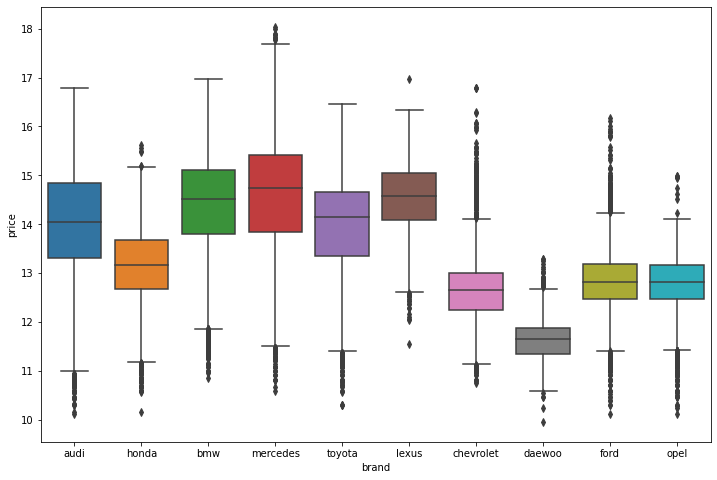

In [74]:
boxplots (df[df.brand.isin(exp_brands + cheap_brands)], ['brand'] , 'price')

Предварительный вывод по популярным автомобилям, которые присуствуют на рынке  
Самые дорогие бренды:
- mersedes
- bmw

В среднем дорогиe бренды:
- toyota
- lexus
- audi
- и др

В среднем дешевыe бренды:
- ford
- chevrolet
- opel
- и др.


### body

In [75]:
df.body.value_counts()

внедорожник 5 дв.          64567
седан                      54614
хэтчбек 5 дв.              12614
лифтбек                     8570
универсал 5 дв.             5847
                           ...  
№ rk31***********              1
№ vy12***********              1
№ hc35-***********             1
универсал 5 дв. shuttle        1
родстер roadster               1
Name: body, Length: 273, dtype: int64

Видим, что частично спарсили что-то не то.
Поэтому избавиться от малых значений нужно обязательно.  
Но сначала объеденим похожие кузова

In [76]:
df.body.value_counts().head(30)

внедорожник 5 дв.                  64567
седан                              54614
хэтчбек 5 дв.                      12614
лифтбек                             8570
универсал 5 дв.                     5847
минивэн                             3523
компактвэн                          2919
купе                                2772
хэтчбек 3 дв.                       2146
седан long                           991
пикап двойная кабина                 916
внедорожник 3 дв.                    542
купе-хардтоп                         405
кабриолет                            330
хэтчбек 3 дв. gtc                    298
родстер                              287
фургон                               259
лифтбек gran turismo                 196
минивэн long                         160
хэтчбек 5 дв. sportback              125
хэтчбек 5 дв. stepway                122
седан gran coupe                     111
минивэн xl                            92
лифтбек sportback                     88
минивэн l       

In [77]:
# объеденим схожие по кузову автомобили
for body in ['внедорожник', 'седан', 'лифтбек', 
             'хэтчбек', 'купе', 'пикап', 
             'универсал', 'фургон', 'кабриолет', 
             'родстер', 'минивэн', 'компактвэн', 
             'лимузин']:
    df.loc[df['body'].str.contains(body, na = False), 'body'] = body

In [78]:
df.body.value_counts().head(30)

внедорожник           65401
седан                 55883
хэтчбек               15542
лифтбек                8870
универсал              5920
минивэн                4096
купе                   3186
компактвэн             3090
пикап                  1130
кабриолет               340
родстер                 290
фургон                  278
микровэн                 59
лимузин                  15
тарга                     7
фастбек                   4
тарга targa               4
№ rp3-1***********        3
№ gb5-1***********        3
№ bb71***********         2
№ gd1-1***********        2
№ rk5-1***********        2
№ gp3-1***********        2
№ rn6-3***********        2
№ rp41***********         2
№ cf41***********         2
№ rf11***********         2
№ db61***********         2
№ bb6-1***********        2
№ rd1-5***********        2
Name: body, dtype: int64

In [79]:
less_than_p (df, 'body', 0.001)

микровэн              0.000359
лимузин               0.000091
тарга                 0.000043
фастбек               0.000024
тарга targa           0.000024
                        ...   
№ rb41***********     0.000006
№ rn3-1***********    0.000006
№ hh5-1***********    0.000006
№ rg11***********     0.000006
№ gb51***********     0.000006
Name: body, Length: 111, dtype: float64

In [80]:
to_mode = less_than_p (df, 'body', 0.001).index.to_list()

In [81]:
# заменим их на моду по бренду
for brand in df.brand.unique():
    df.loc[(df.body.isin(to_mode)) & (df.brand == brand), 'body'] = df.loc[df.brand == brand, 'body'].mode()[0]

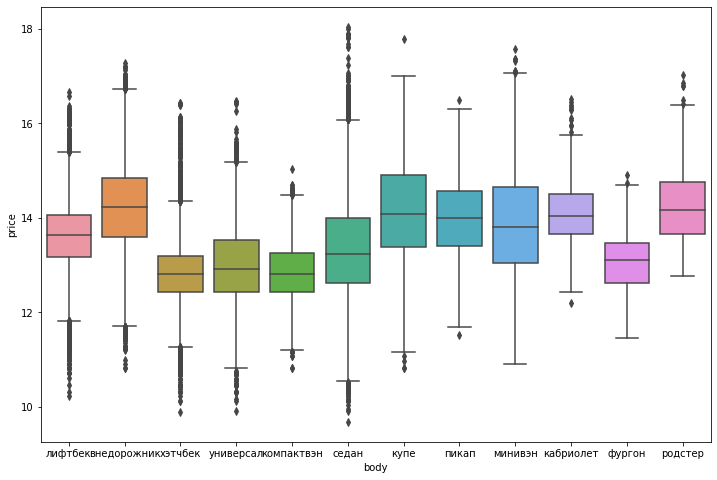

In [82]:
boxplots(df, ['body'], 'price')


body



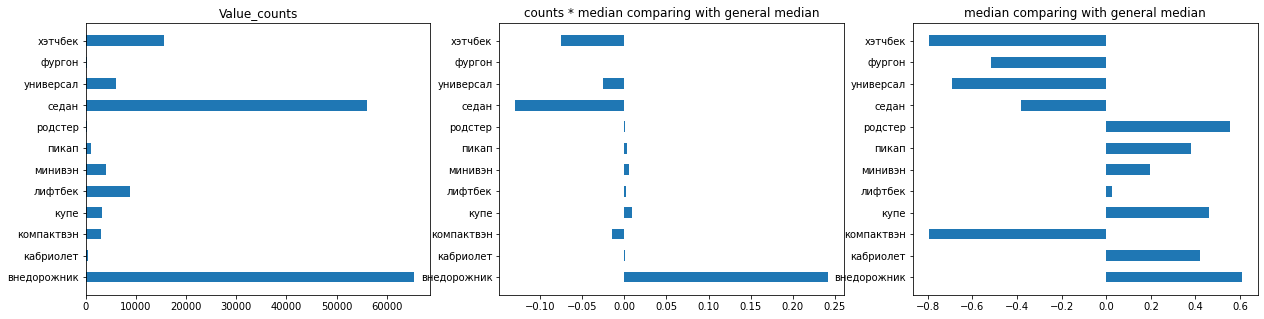

In [83]:
print_barhs_reg_median (df, ['body'], 'price')

In [84]:
compare_medians(df, 'body', 'price')

внедорожник    0.242564
купе           0.008939
минивэн        0.004949
пикап          0.002620
лифтбек        0.001335
родстер        0.000983
кабриолет      0.000873
фургон        -0.000872
компактвэн    -0.014972
универсал     -0.024984
хэтчбек       -0.075321
седан         -0.130091
dtype: float64

Cреди самых распространённых кузовов:
- внедорожник, купе и минивэн стоят в среднем дороже других автомобилей
- седан, хэтчбэк, универсал и лифтбек в среднем стоят дешевле других автомобилей

### color

In [85]:
df.color.value_counts()

чёрный         24014
040001         23620
белый          16570
fafbfb         14661
cacecb         10973
97948f         10260
серый          10139
0000cc          8403
серебристый     7937
синий           7430
ee1d19          4423
коричневый      3631
красный         3586
200204          3349
007f00          2516
зелёный         1878
c49648          1811
бежевый         1463
22a0f8          1338
голубой          906
dea522           765
660099           738
ffd600           692
4a2197           596
ff8649           481
золотистый       472
пурпурный        461
фиолетовый       427
жёлтый           345
оранжевый        301
розовый           29
ffc0cb            25
Name: color, dtype: int64

Попались закодированные цвета.

In [86]:
colors = {'040001': 'чёрный', 'fafbfb': 'белый', '97948f': 'серый', 'cacecb': 'серебристый', '0000cc': 'синий', '200204': 'коричневый',
              'ee1d19': 'красный',  '007f00': 'зелёный', 'c49648': 'бежевый', '22a0f8': 'голубой', '660099': 'пурпурный', 'dea522': 'золотистый', 
              '4a2197': 'фиолетовый', 'ffd600': 'жёлтый', 'ff8649': 'оранжевый', 'ffc0cb': 'розовый'}

In [87]:
df.color.replace(to_replace=colors, inplace=True)


color



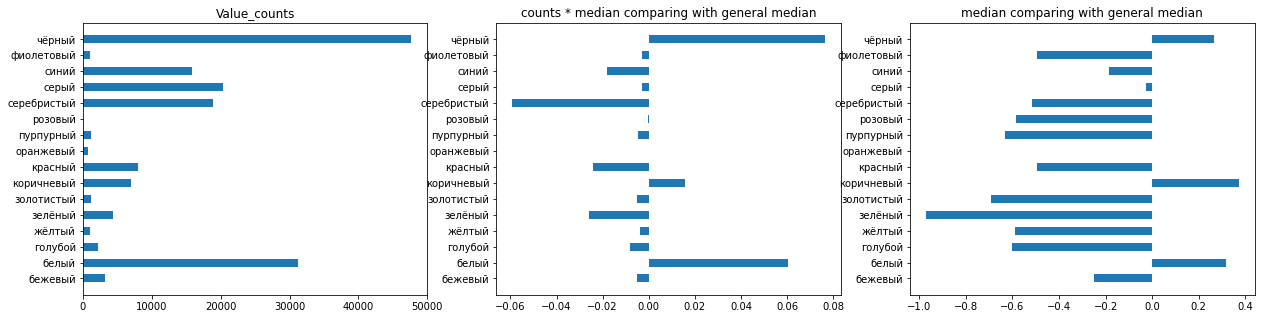

In [88]:
print_barhs_reg_median (df, ['color'], 'price')

In [89]:
df.loc[df['color'] == 'розовый' , 'color'] = 'пурпурный'

Промежуточные выводы:
1. Автомобили в популярных строгих цветах (черный и белый) в среднем стоят дороже. 
2. Автомобили в серебристом цвете в среднем стоят дешевле.

### fuel

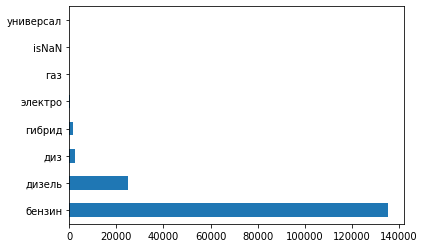

In [90]:
df.fuel.value_counts().plot(kind = 'barh')

In [91]:
df.fuel.value_counts()

бензин       135510
дизель        24755
диз            2247
гибрид         1400
электро         287
газ              39
isNaN             1
универсал         1
Name: fuel, dtype: int64

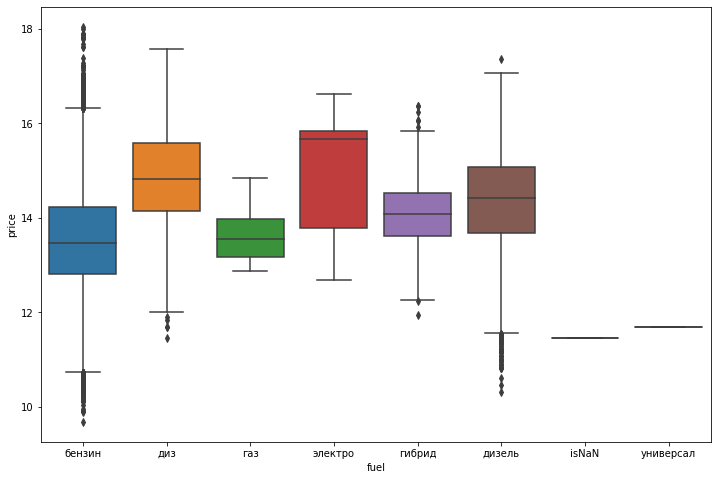

In [92]:
boxplots(df, ['fuel'], 'price')

In [93]:
df.loc[df['fuel'].str.contains('диз'), 'fuel'] = 'дизель'
# мало автомобилей на газу
df.loc[df['fuel'].isin(['универсал', 'isNaN', 'газ']), 'fuel'] = 'бензин' 


fuel



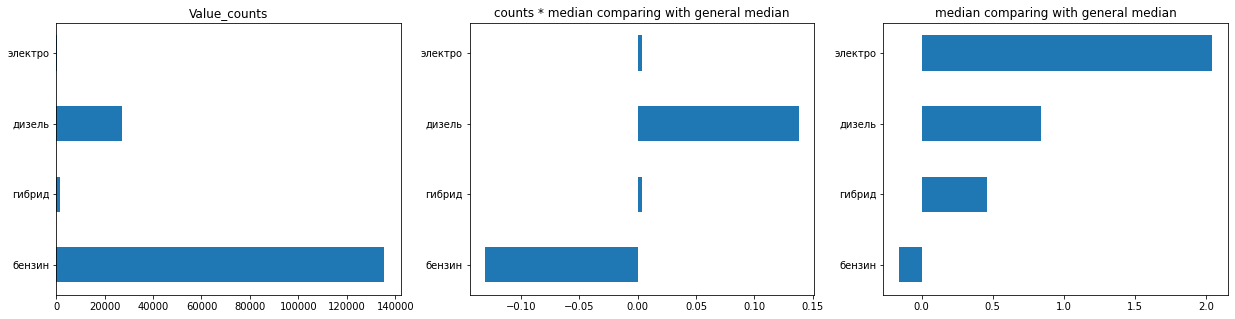

In [94]:
print_barhs_reg_median(df, ['fuel'], 'price')

Промежуточный вывод:  
Автомобили на бензине широко распространены, но стоят в среднем дешевле автомобилей на другом топливе.

### transmission

In [95]:
df.transmission.value_counts()

automatic           46826
автоматическая      44976
mechanical          24872
механическая        14122
роботизированная     9427
вариатор             9407
robot                7321
variator             5631
вариат               1656
isNaN                   2
Name: transmission, dtype: int64

In [96]:
df.loc[df.transmission.isin(['automatic', 'вариат', 'variator', 'robot', 'роботизированная','вариатор',]), 'transmission'] = 'автоматическая'
df.loc[df.transmission.isin(['mechanical','isNaN']), 'transmission'] = 'механическая'

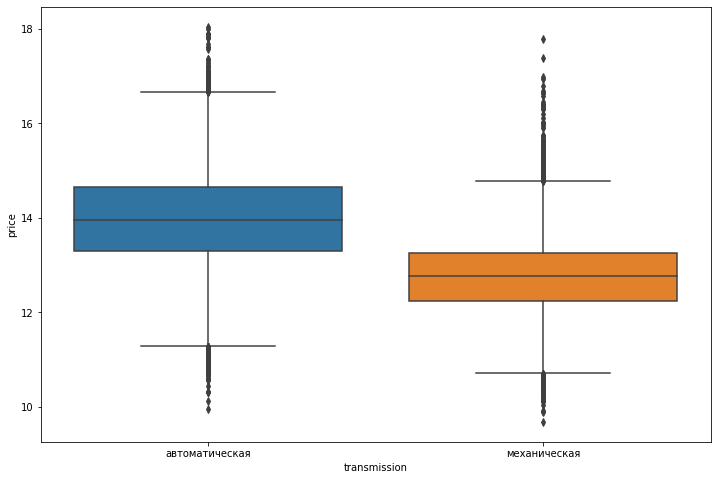

In [97]:
boxplots(df, ['transmission'],'price')

Промежуточный вывод:  
Автомобили на c механической коробкой передач в среднем дешевле автомобилей с автоматической коробкой передач.

### passport

In [98]:
df.passport.value_counts()

original     73996
оригинал     61856
duplicate    10307
дубликат      9220
isNaN         8861
Name: passport, dtype: int64

In [99]:
df.loc[df.passport.isin(['original']), 'passport'] = 'оригинал'
df.loc[df.passport.isin(['duplicate']), 'passport'] = 'дубликат'

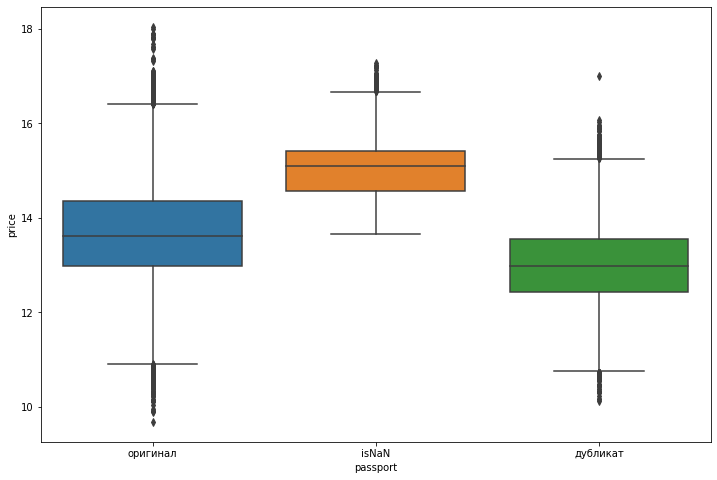

In [100]:
boxplots(df, ['passport'],'price')

Промежуточный вывод:  
Автомобили имеющие дубликат паспорта, а не оригинал в среднем дешевле.

### drive

In [101]:
df.drive.value_counts()

передний    77060
полный      68096
задний      13656
isNaN        5428
Name: drive, dtype: int64

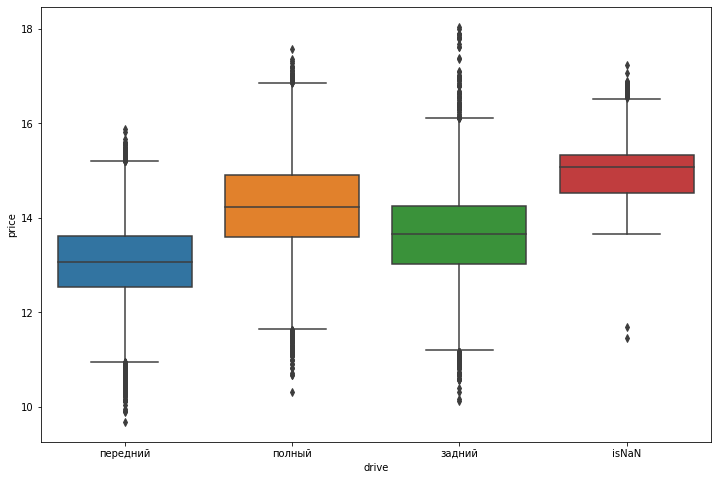

In [102]:
boxplots(df, ['drive'],'price')

Промежуточный вывод:
Автомобили с передним приводом в среднем дешевле остальных автомобилей.

### steering

In [103]:
df.steering.value_counts()

left      82875
левый     67330
isNaN      8513
правый     3746
right      1776
Name: steering, dtype: int64

In [104]:
df.loc[df.steering.isin(['left']), 'steering'] = 'левый'
df.loc[df.steering.isin(['right']), 'steering'] = 'правый'

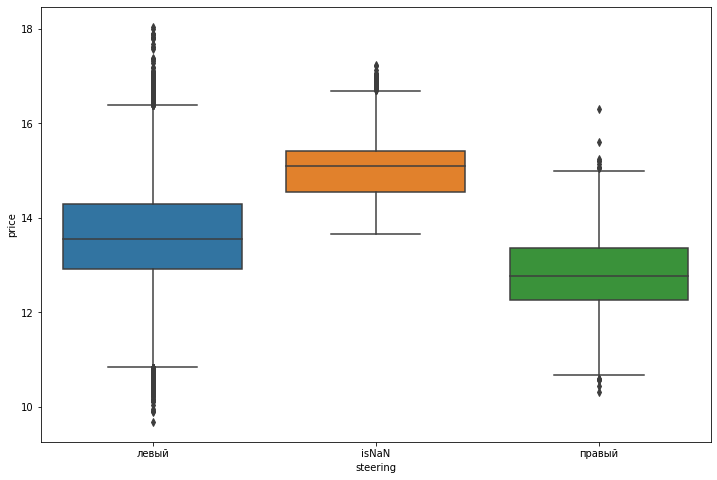

In [105]:
boxplots(df, ['steering'],'price')

Промежуточный вывод:  
Праворульных автомобилей продаётся немного и в среднем они дешевле.

### owner_count

In [106]:
df.owner_count.value_counts()

 3.0    66399
 1.0    40547
 2.0    38985
-1.0    18309
Name: owner_count, dtype: int64

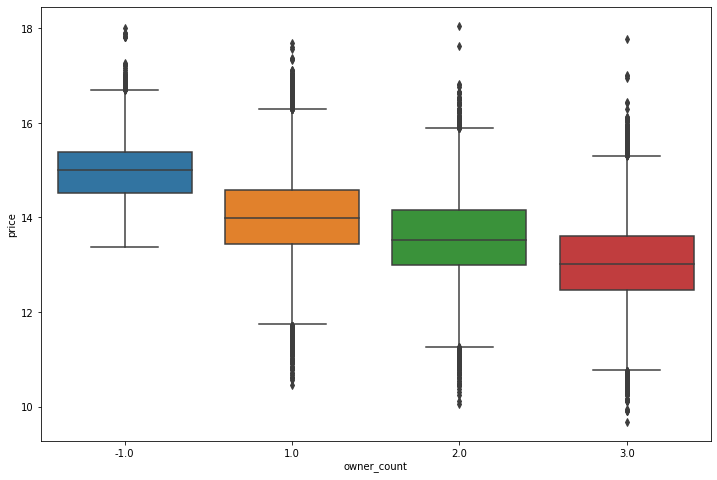

In [107]:
boxplots(df, ['owner_count'],'price')

Промежуточный вывод:  
Чем больше у автомобиля было владельцев, тем дешевле автомобиль.

### num_doors

In [108]:
df.num_doors.value_counts()

 5.0    91182
 4.0    56740
-1.0     9321
 2.0     3820
 3.0     3175
 0.0        2
Name: num_doors, dtype: int64

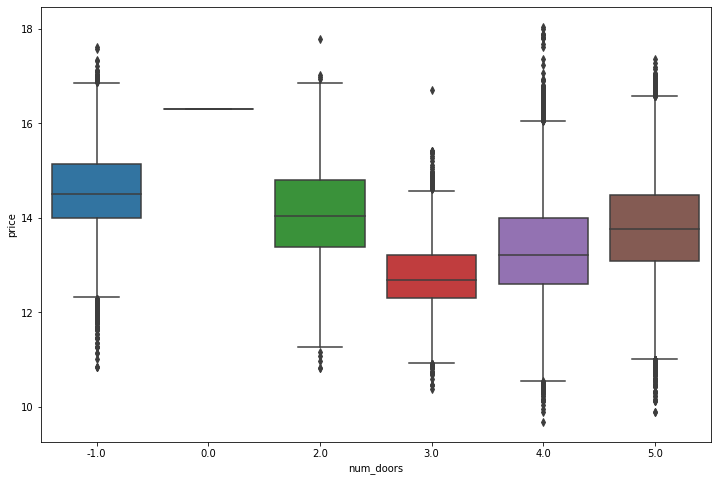

In [109]:
boxplots(df, ['num_doors'],'price')

In [110]:
df[df.num_doors == 0.0]

,body,model,brand,color,fuel,transmission,passport,drive,steering,owner_count,num_doors,parsing_year,region,engine_volume,engine_power,prod_date,mileage,description,price,test
128267,кабриолет,simplex,mercedes,белый,бензин,механическая,оригинал,задний,правый,1.0,0.0,2020,isNaN,5.3,32.0,1904.0,48000.0,785.0,16.300417,0
146498,кабриолет,simplex,mercedes,белый,бензин,механическая,оригинал,задний,правый,1.0,0.0,2020,в москве,5.3,32.0,1904.0,48000.0,785.0,NaN,1


In [111]:
df.loc[df.num_doors == 0.0, 'num_doors'] = 2


num_doors



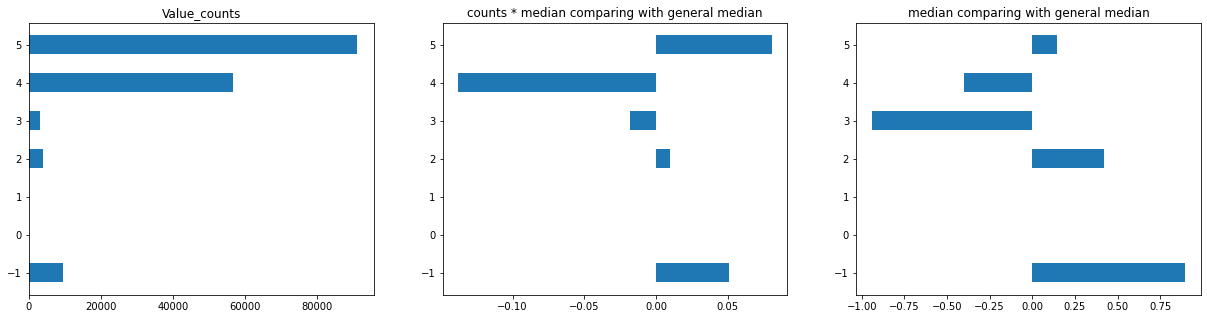

In [112]:
print_barhs_reg_median(df, ['num_doors'], 'price')

Промежуточный вывод:  
Трёхдверные автомобили стоят дешевле остальных автомобилей.

### region

In [113]:
df.region.value_counts().head(20)

isNaN                 99396
в москве              43318
в санкт-петербурге     2929
в красноярске          1250
в екатеринбурге         950
в краснодаре            796
в новосибирске          731
в ростове-на-дону       505
в челябинске            454
в нижнем новгороде      449
в казани                444
в уфе                   419
в воронеже              376
в тюмени                306
в самаре                267
в перми                 265
в химках                248
в иркутске              243
во владивостоке         239
в омске                 232
Name: region, dtype: int64

In [114]:
less_than_p (df, 'region', 0.0025).index

Index(['в воронеже', 'в тюмени', 'в самаре', 'в перми', 'в химках',
       'в иркутске', 'во владивостоке', 'в омске', 'в волгограде', 'в минске',
       ...
       'в поселке совхоза комсомолец', 'в петропавловске', 'в усть-куте',
       'в преображенской', 'в шексне', 'в новом атлашево', 'в кушве',
       'в виноградном', 'в бураево', 'в лосино-петровском'],
      dtype='object', length=1266)

In [115]:
df.loc[df.region.isin(less_than_p (df, 'region', 0.0025).index.to_list()), 'region'] = 'в другом городе'

In [116]:
#мы знаем как формировалась выборка, поэтомй значем, что пропуски - это автомобили в Москве
df.loc[df.region == 'isNaN', 'region'] = 'в москве'

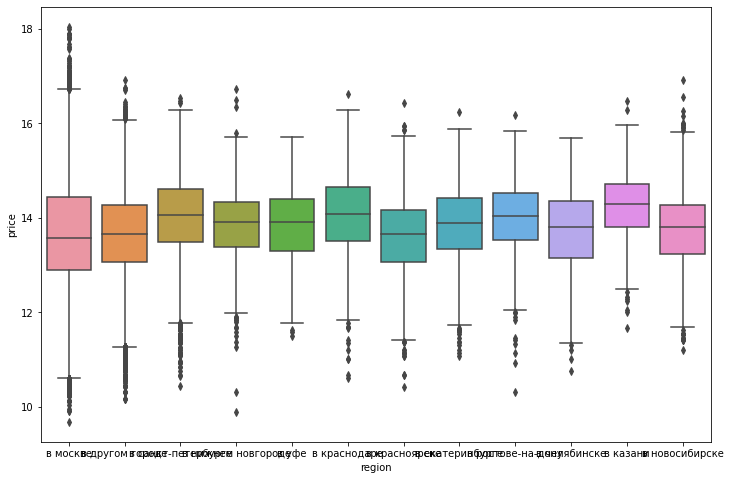

In [117]:
boxplots(df, ['region'],'price')

### model 

In [118]:
df.model.value_counts()

octavia               4219
5er                   3241
polo                  2999
3er                   2749
e_klasse              2694
                      ... 
sidekick                 1
zephyr                   1
orion                    1
ltd_crown_victoria       1
will_cypha               1
Name: model, Length: 1157, dtype: int64

Очень много разных марок, но марки автомобиля важны. Т.к. автомобили редкие, то заменять модой их не совсем верно. Поэтому отсортируем внутри каждого бренда модели по медианной цене, и объеденим ближайшие модели до приемлимого количества автомобилей.

In [119]:
less_than_p (df, 'model', 0.001)

hilux                 0.000980
x5_m                  0.000962
mark_ii               0.000919
q8                    0.000913
antara                0.000907
                        ...   
sidekick              0.000006
zephyr                0.000006
orion                 0.000006
ltd_crown_victoria    0.000006
will_cypha            0.000006
Name: model, Length: 961, dtype: float64

In [120]:
col_1 = 'brand'
col_2 = 'model'
target ='price'

for brand in df.brand.unique():
    temp_2 = df[df.brand == brand].copy()
    temp_2 = order_values_median (temp_2, ['model'], 'price')
    temp_2, model_bins = col_by_bins (temp_2, ['model'], 0.10)
    df.loc[temp_2.index, 'model'] = df.loc[temp_2.index, 'brand'] + '_' + temp_2[model_bins[0]].apply(str)

In [121]:
# количество полученных моделей
df.model.nunique()

182

In [122]:
# посмотрим на количество моделей в каждом бренде
for brand in df.brand.unique():
    print (brand, df[df.brand == brand]['model'].nunique())

skoda 4
audi 6
honda 5
volvo 5
bmw 6
nissan 7
infiniti 6
mercedes 7
toyota 6
lexus 5
volkswagen 5
mitsubishi 5
cadillac 4
chery 5
chevrolet 6
chrysler 6
citroen 6
daewoo 2
dodge 5
ford 4
geely 6
hyundai 6
jaguar 5
jeep 4
kia 6
mazda 5
mini 2
opel 5
peugeot 6
porsche 3
renault 7
subaru 4
suzuki 5
great_wall 4
land_rover 5
ssang_yong 4


Взглянем на часть основных брендов из тестовой выборки и их модели, а также их влияние на цену.

In [123]:
trend_brands = df[df['test'] == 1].brand.unique()

skoda


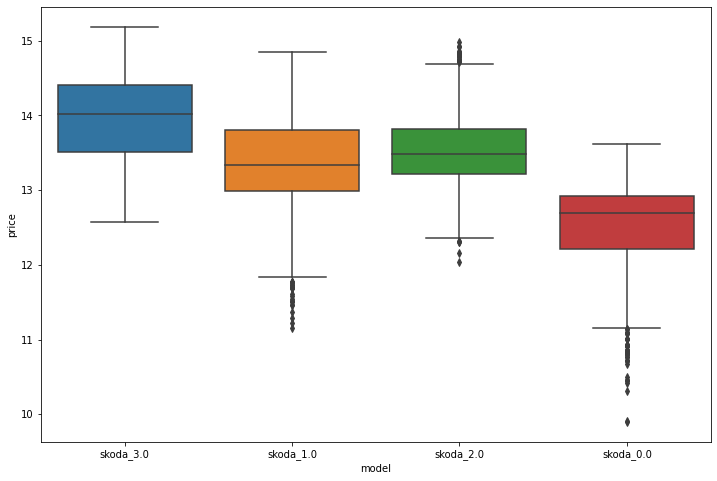

audi


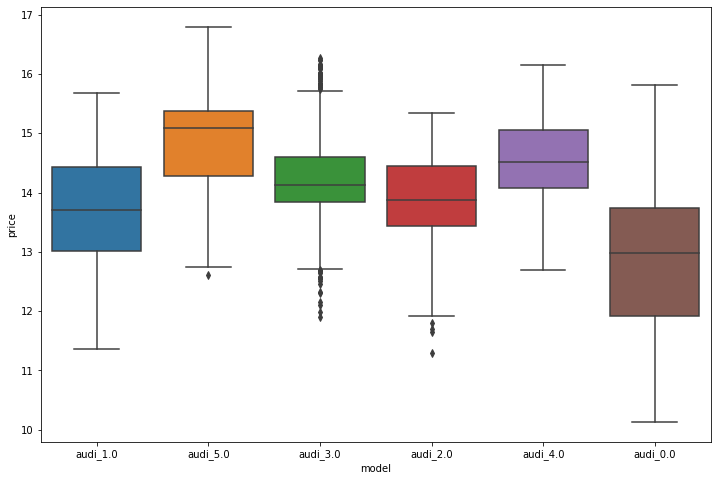

honda


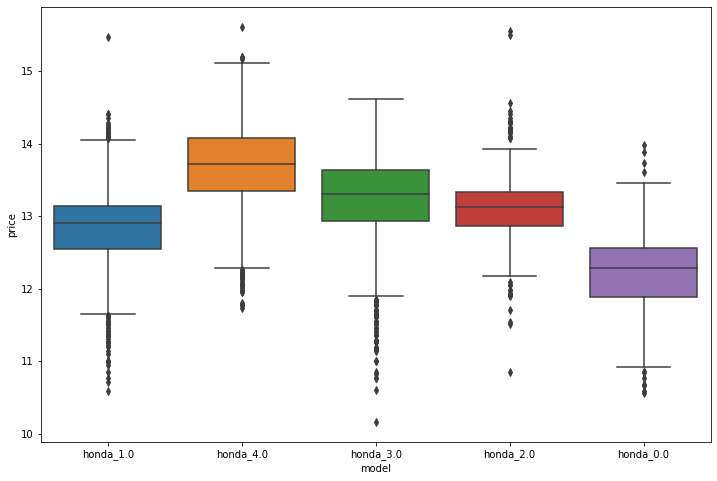

volvo


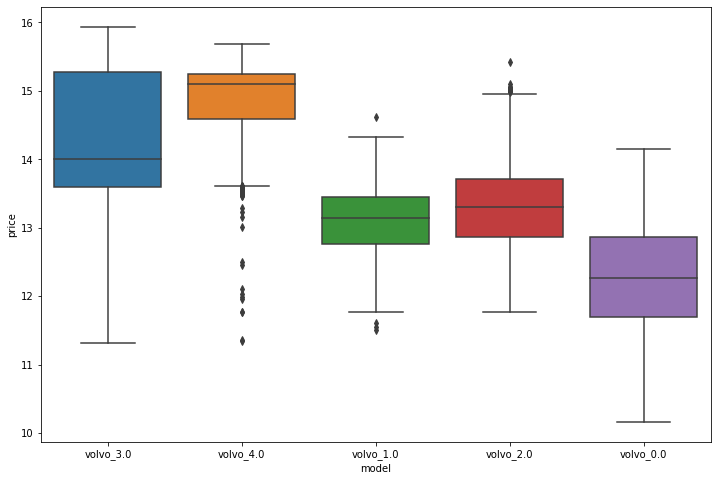

bmw


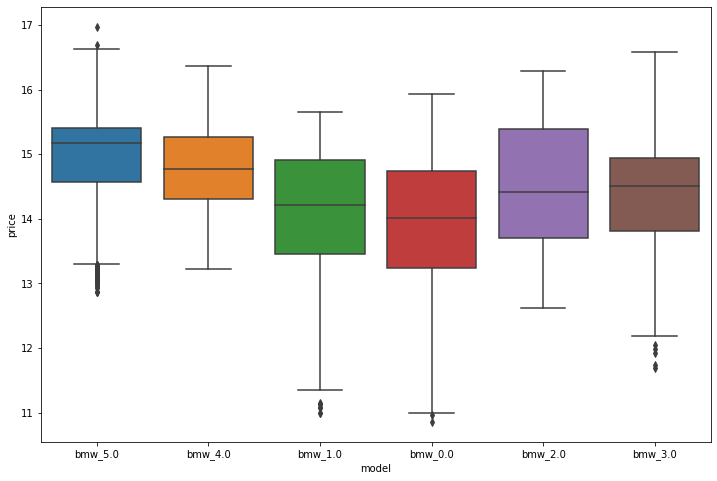

nissan


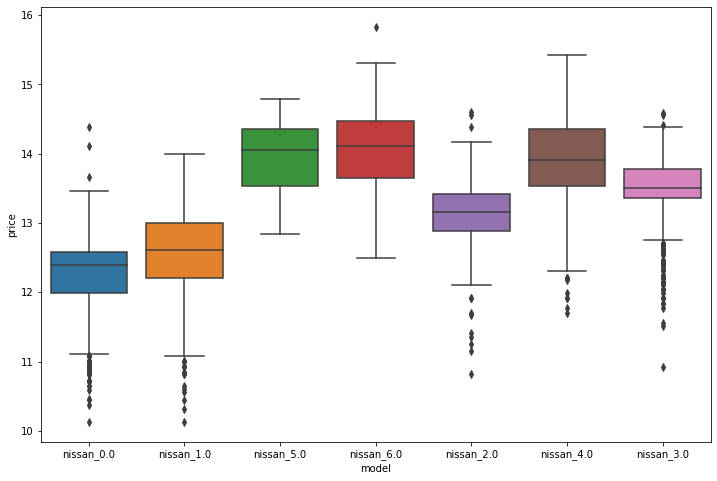

infiniti


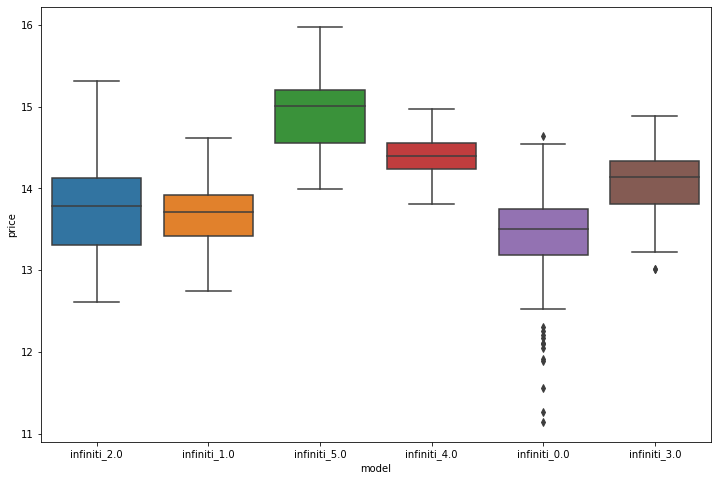

mercedes


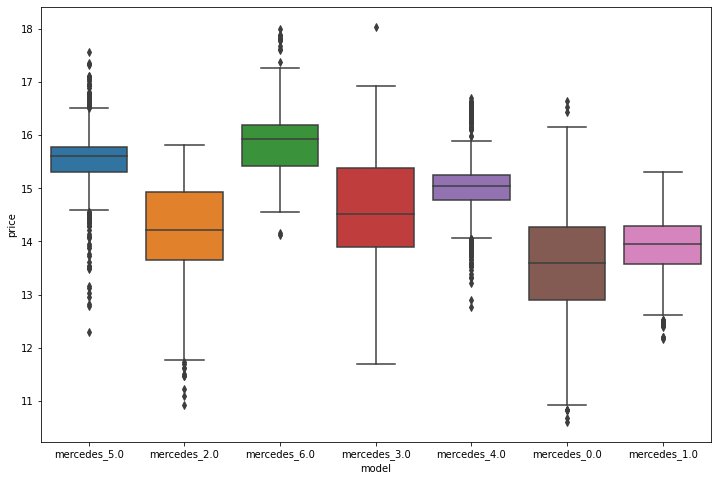

toyota


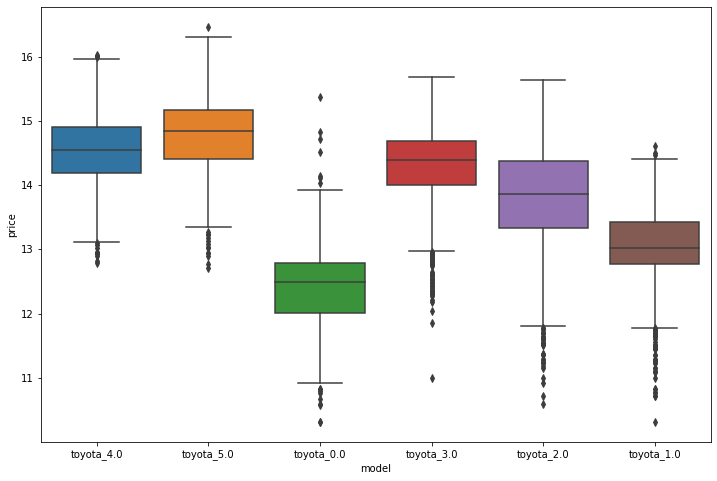

lexus


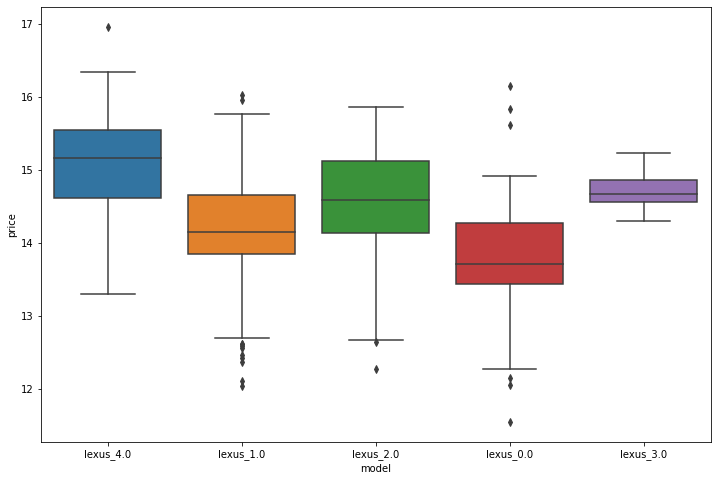

volkswagen


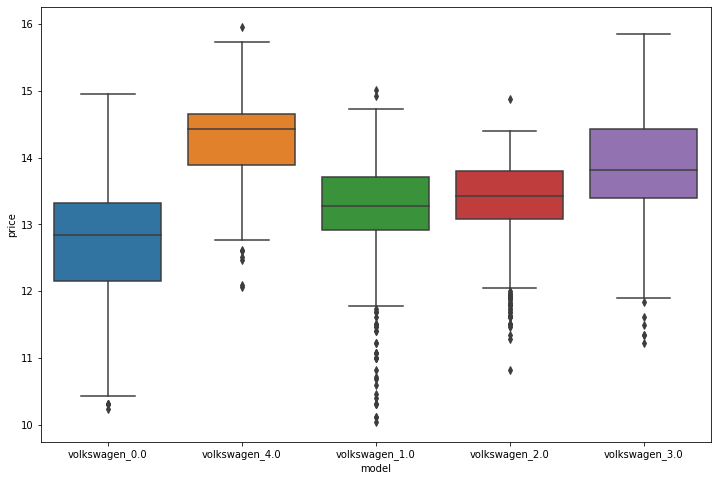

mitsubishi


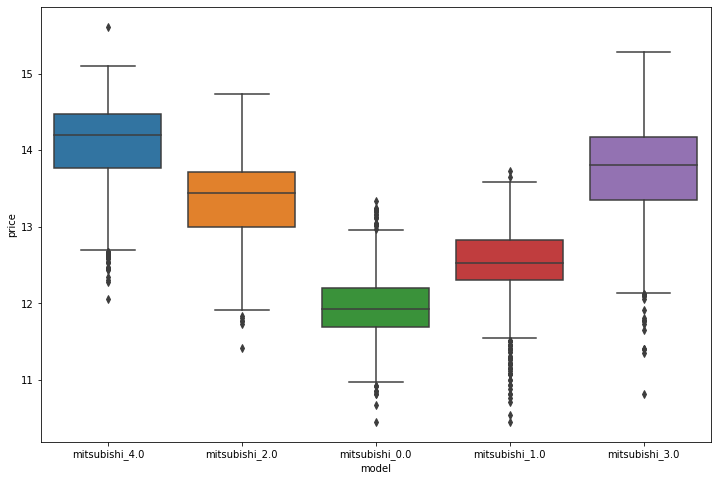

In [124]:
for brand in trend_brands:
    print (brand)
    boxplots(df[df.brand == brand], ['model'], 'price')

Промежуточный вывод:  
От модели автомобиля сильно зависит цена автомобиля, разница видна внутри бренда.

## Числовые признаки

Посмотрим на распределения, сравним с логарифмированным распределнием. Обратим внимание на учаски с возможными выбросами. Заполним пропуски. Посмотрим на корреляцию признаков с целевой переменной.

In [125]:
df[num_cols].isna().sum()

engine_volume     3508
engine_power       186
prod_date         3086
mileage           8512
description      12531
dtype: int64

### engine_volume

Мы заранее немного подправили ситуацию с engine_volume. (ранее обнаружились неправдоподобно большие значения объёма двигателя).

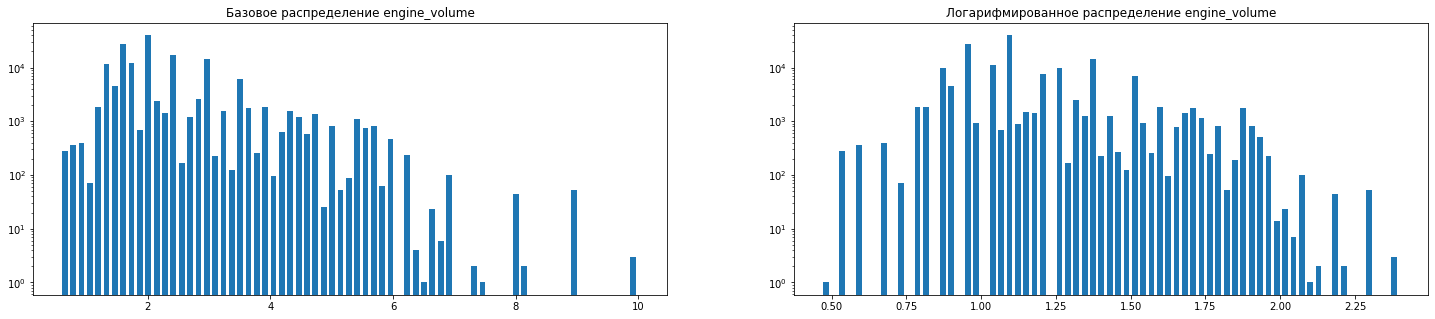

In [126]:
hist_log_compare(df, ['engine_volume'])

In [127]:
df['engine_volume'] = np.log(df['engine_volume'] + 1)

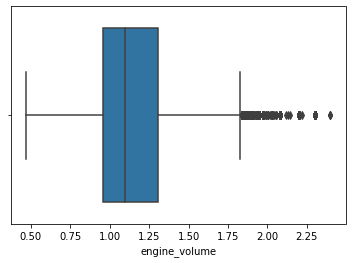

In [128]:
sns.boxplot(data = df , x = 'engine_volume')

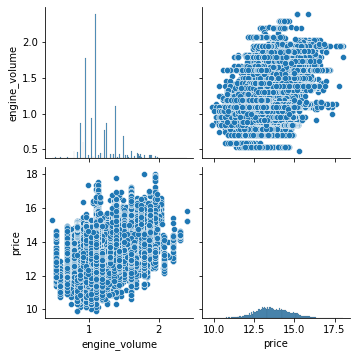

In [129]:
sns.pairplot(df[['engine_volume', 'price']])

Разобьём все значения признака на небольшие корзины и посмотрим как влияют на целевую переменную разные участки признака.


engine_volume_bins0.05



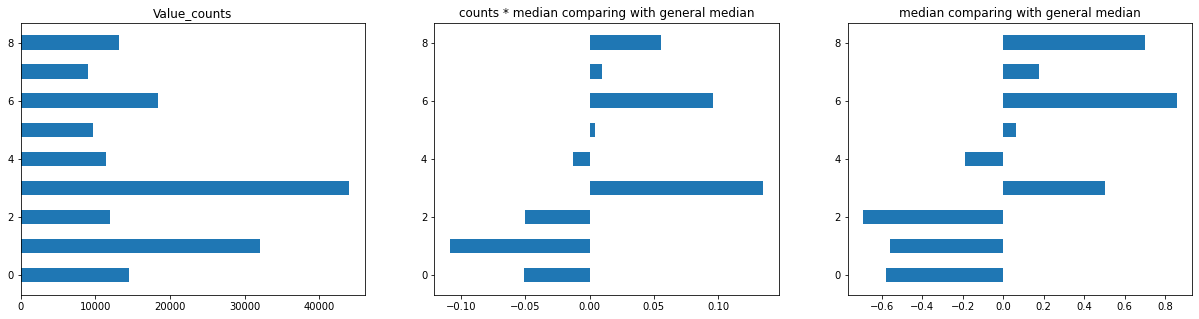

In [130]:
df, bin_col  = col_by_bins_fillna_median (df, ['engine_volume'], 0.05)
print_barhs_reg_median (df, bin_col, 'price')

Чем выше объём двигателя, тем в среднем автомобиль дороже, но при минимальных и максимальных значенях объём двигателя влияет на цену сильнее.

### engine_power

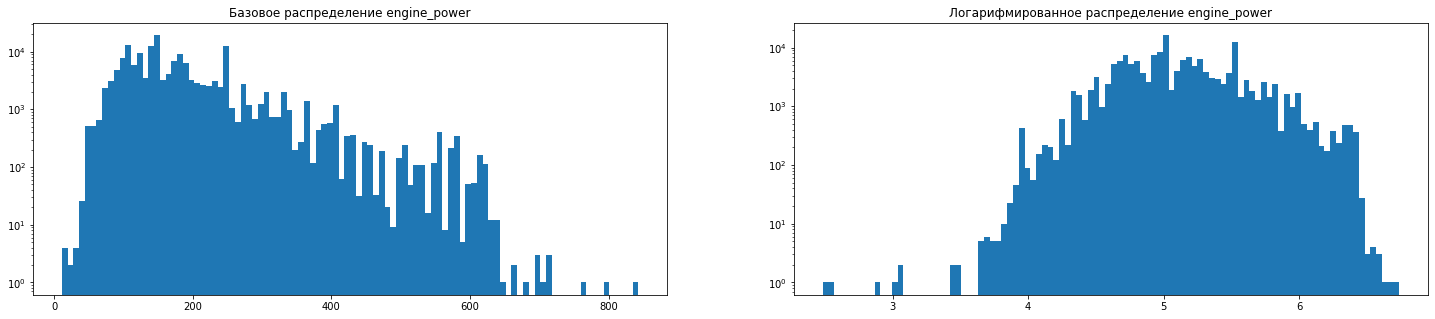

In [131]:
hist_log_compare(df, ['engine_power'])

Признак можно прологарифмировать.

In [132]:
df['engine_power'] = np.log(df['engine_power'] + 1)

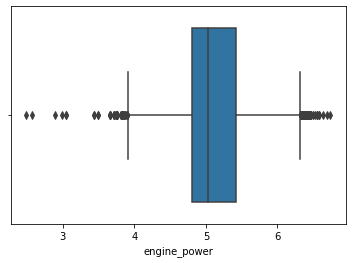

In [133]:
sns.boxplot(data = df , x = 'engine_power')

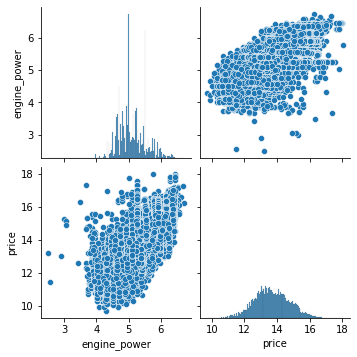

In [134]:
sns.pairplot(df[['engine_power', 'price']])

Имеет смысл обратить на области с низким показателем мощности автомобиля.

In [135]:
df[df['test'] == 1]['engine_power'].min()

3.4339872044851463

In [136]:
df[df['engine_power'] < 3.4]

,body,model,brand,color,fuel,transmission,passport,drive,steering,owner_count,num_doors,parsing_year,region,engine_volume,engine_power,prod_date,mileage,description,price,test,engine_volume_bins0.05
9312,хэтчбек,bmw_5.0,bmw,бежевый,бензин,механическая,оригинал,задний,левый,3.0,-1.0,2022,в москве,0.470004,2.995732,1959.0,79000.0,NaN,15.296331,0,0
18812,седан,honda_1.0,honda,пурпурный,бензин,механическая,оригинал,isNaN,левый,3.0,-1.0,2021,в ростове-на-дону,NaN,2.564949,1989.0,220000.0,27.0,11.459826,0,3
66658,кабриолет,ford_3.0,ford,зелёный,бензин,механическая,оригинал,задний,левый,1.0,2.0,2020,в москве,1.360977,3.044522,1923.0,1000.0,395.0,15.150512,0,6
66659,кабриолет,ford_3.0,ford,чёрный,бензин,механическая,оригинал,задний,левый,1.0,2.0,2020,в москве,1.360977,3.044522,1924.0,30000.0,476.0,14.914123,0,6
101792,купе,renault_5.0,renault,белый,электро,автоматическая,оригинал,задний,левый,2.0,2.0,2020,в москве,NaN,2.890372,2012.0,1959.0,191.0,13.014780,0,3
101793,купе,renault_5.0,renault,чёрный,электро,автоматическая,оригинал,задний,левый,2.0,2.0,2020,в москве,NaN,2.484907,2016.0,1800.0,213.0,13.215856,0,3


Удалим совсем маломощные современные автомобили.

In [137]:
df.drop(df[(df['engine_power'] < 3.4) & (df['prod_date'] > 2000)].index, inplace = True)
df.index = range(len(df))

Разобьём все значения признака на небольшие корзины и посмотрим как влияют на целевую переменную разные участки признака.


engine_power_bins0.05



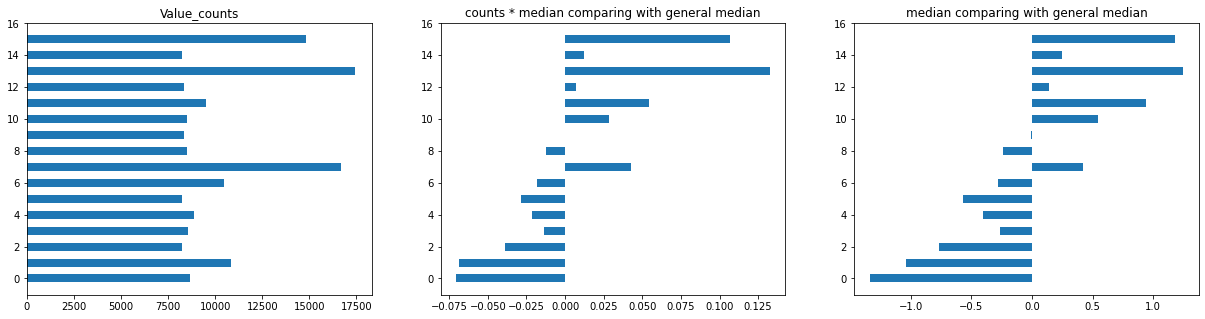

In [138]:
df, bin_col = col_by_bins_fillna_median (df, ['engine_power'], 0.05)
print_barhs_reg_median (df, bin_col, 'price')

Чем мощность двигателя выше, тем в среднем автомобиль дороже.

### prod_date

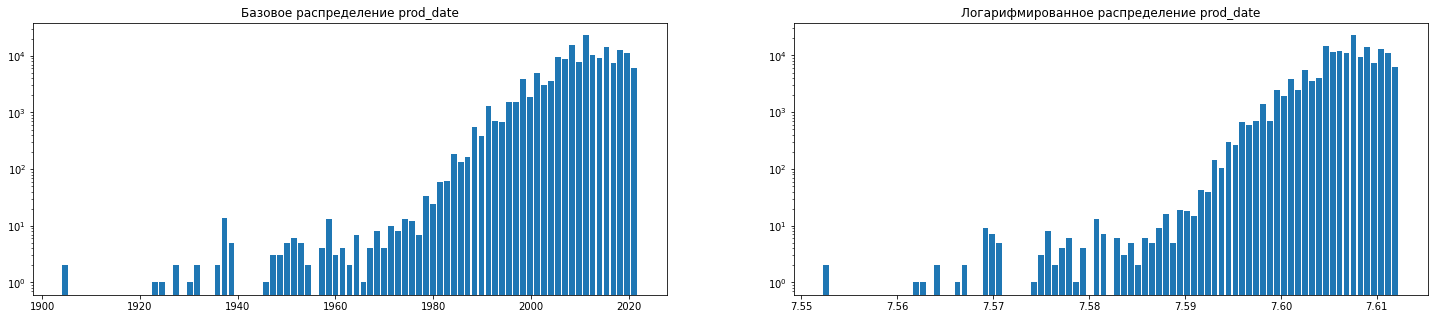

In [139]:
hist_log_compare(df, ['prod_date'])

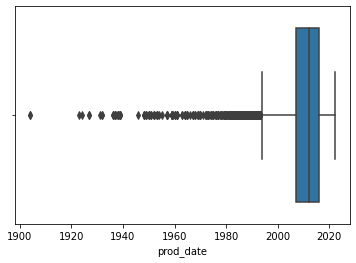

In [140]:
sns.boxplot(data = df , x = 'prod_date')

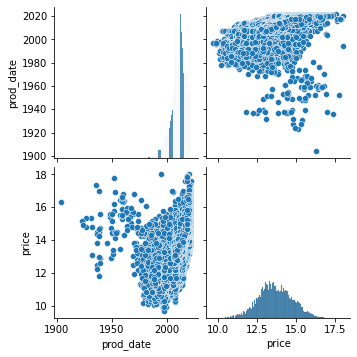

In [141]:
sns.pairplot(df[['prod_date', 'price']])

У нас старички есть в тесте, поэтому чистить минимальные значения нельзя.

Разобьём все значения признака на небольшие корзины и посмотрим как влияют на целевую переменную разные участки признака.   
Разобъём корзины с малой долей p_min, чтобы увидеть как на цену влияют совсем старые и совсем новые автомобили.


prod_date_bins0.001



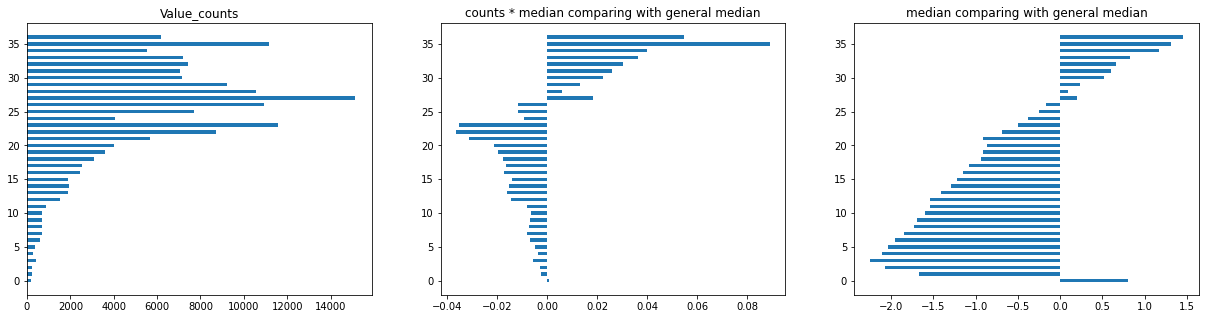

In [142]:
df, bin_col = col_by_bins_fillna_median (df, ['prod_date'], 0.001)
print_barhs_reg_median (df, bin_col, 'price')

Мы видим, что новые автомобили в среднем дороже. И до какого-то определённого времени со временем автомобили дешевеют. Затем со временем они переходят в разряд раритетных и уже начинают оцениваться дороже. Хоть их и не много, отметим их, как раритетные.

In [143]:
df.loc[df['prod_date_bins0.001'].isin(range(0)),'rare'] = 1
df.loc[df['prod_date_bins0.001'].isin(range(27,39)),'new'] = 1

In [144]:
new_cat_feats = ['rare', 'new']
df.loc[:, new_cat_feats] = df.loc[:, new_cat_feats].apply(lambda x: x.fillna(0))


prod_date_bins0.05



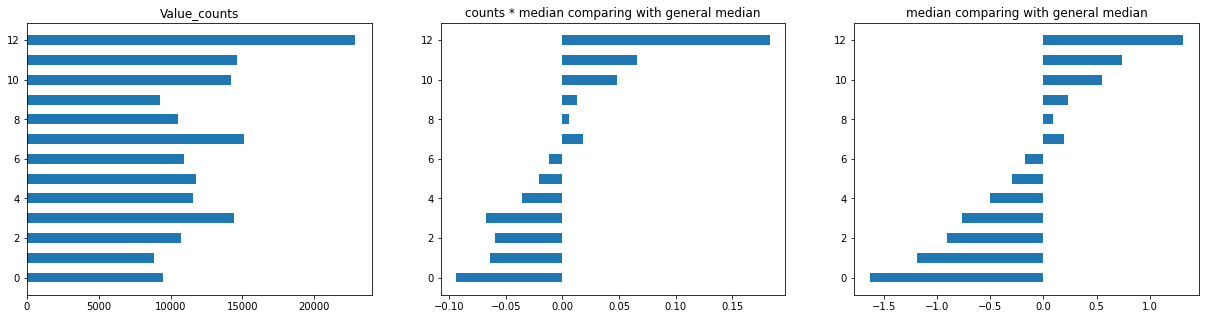

In [145]:
df, bin_col = col_by_bins_fillna_median (df, ['prod_date'], 0.05)
print_barhs_reg_median (df, bin_col, 'price')

Чем автомобиль старше, тем в среднем автомобиль дешевле. За исключением некоторых раритетных автомобилей.

### mileage

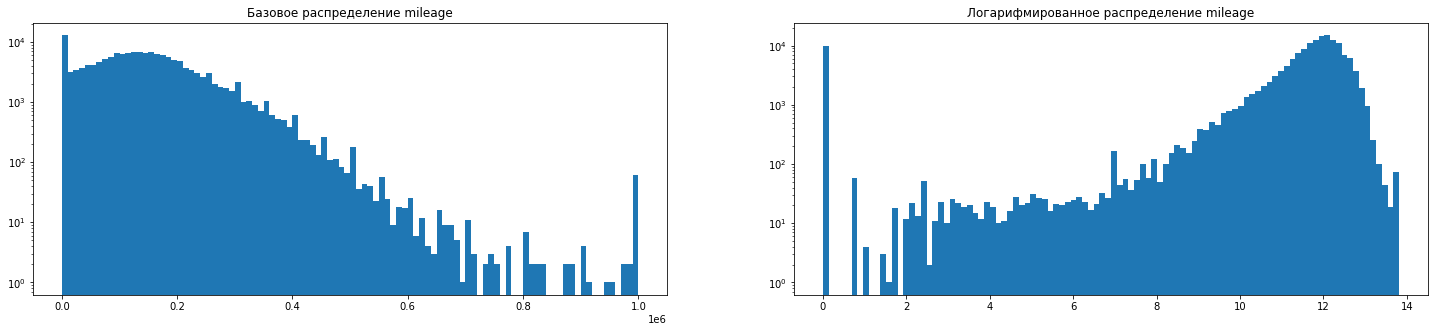

In [146]:
hist_log_compare(df, ['mileage'])

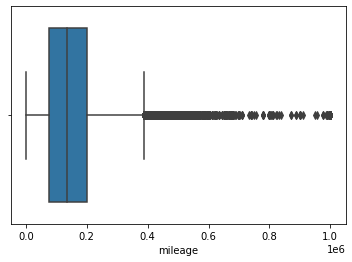

In [147]:
sns.boxplot(data = df , x = 'mileage')

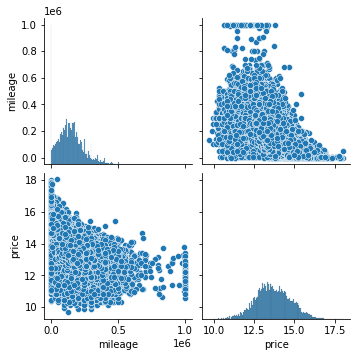

In [148]:
sns.pairplot(df[['mileage', 'price']])

Разобьём все значения признака на небольшие корзины и посмотрим как влияют на целевую переменную разные участки признака.


mileage_bins0.05



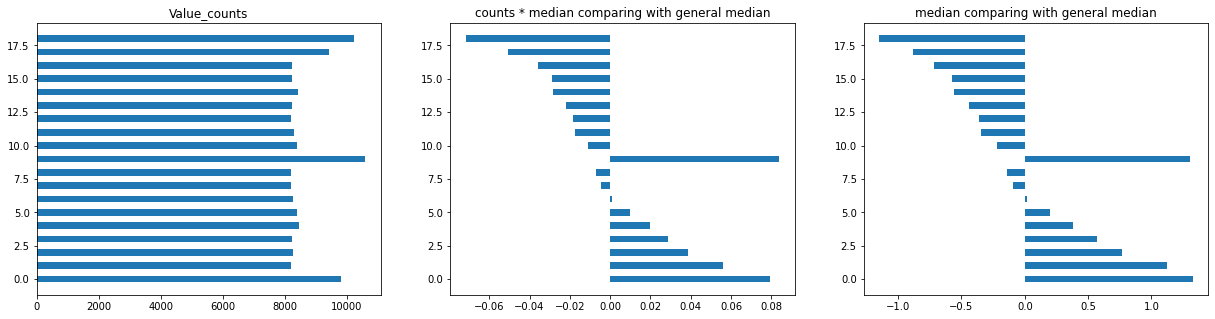

In [149]:
df, bin_col = col_by_bins_fillna_median (df, ['mileage'], 0.05)
print_barhs_reg_median (df, bin_col, 'price')

Видим неадекватно расположенный на графике бар. Это мы для наглядности заменили пустые значения медианной, но эти автомобили существенно дороже тех, автомобилей, пробег, которых составляет медиану пробега всех автомобилей. Значит у этих автомобилей должно быть низкий пробег и замена медианой тут неправильное решение. Посмотрим внимательнее.

In [150]:
df[df['mileage'].isna() == True]

,body,model,brand,color,fuel,transmission,passport,drive,steering,owner_count,num_doors,parsing_year,region,engine_volume,engine_power,prod_date,mileage,description,price,test,engine_volume_bins0.05,engine_power_bins0.05,prod_date_bins0.001,rare,new,prod_date_bins0.05,mileage_bins0.05
5,лифтбек,skoda_1.0,skoda,белый,бензин,автоматическая,isNaN,передний,isNaN,-1.0,-1.0,2022,в москве,0.955511,4.709530,NaN,NaN,NaN,14.279207,0,1,3,27,0.0,1.0,7,9
8,лифтбек,skoda_1.0,skoda,серебристый,бензин,автоматическая,isNaN,передний,isNaN,-1.0,-1.0,2022,в москве,0.955511,4.709530,NaN,NaN,NaN,14.313526,0,1,3,27,0.0,1.0,7,9
12,лифтбек,skoda_1.0,skoda,зелёный,бензин,автоматическая,isNaN,передний,isNaN,-1.0,-1.0,2022,в москве,0.955511,4.709530,NaN,NaN,NaN,14.442211,0,1,3,27,0.0,1.0,7,9
17,лифтбек,skoda_1.0,skoda,белый,бензин,автоматическая,isNaN,передний,isNaN,-1.0,-1.0,2022,в москве,0.955511,4.709530,NaN,NaN,NaN,14.254100,0,1,3,27,0.0,1.0,7,9
20,лифтбек,skoda_1.0,skoda,серый,бензин,автоматическая,isNaN,передний,isNaN,-1.0,-1.0,2022,в москве,0.955511,4.709530,NaN,NaN,NaN,14.401489,0,1,3,27,0.0,1.0,7,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44881,внедорожник,mitsubishi_4.0,mitsubishi,чёрный,бензин,автоматическая,isNaN,isNaN,isNaN,-1.0,5.0,2021,в москве,1.098612,4.990433,2021.0,NaN,4414.0,14.376604,0,3,7,36,0.0,1.0,12,9
44885,внедорожник,mitsubishi_4.0,mitsubishi,чёрный,бензин,автоматическая,isNaN,isNaN,isNaN,-1.0,5.0,2021,в москве,1.223775,5.123964,2021.0,NaN,5773.0,14.575148,0,4,9,36,0.0,1.0,12,9
44892,внедорожник,mitsubishi_4.0,mitsubishi,белый,бензин,автоматическая,isNaN,isNaN,isNaN,-1.0,5.0,2021,в москве,1.098612,4.990433,2021.0,NaN,5856.0,14.464452,0,3,7,36,0.0,1.0,12,9
44896,внедорожник,mitsubishi_4.0,mitsubishi,синий,бензин,автоматическая,isNaN,isNaN,isNaN,-1.0,5.0,2021,в москве,1.098612,4.990433,2021.0,NaN,5025.0,14.385906,0,3,7,36,0.0,1.0,12,9


Видим похожие друг на друга автомобили. Нет даты производства, нет даты модели. C учётом влияния на стоимость - возможно это новые автомобили. Давайте заменим пробег на 0 и посмотрим, какие графики получатся в этом случае.

In [151]:
df['mileage'].fillna(0, inplace = True)


mileage_bins0.05



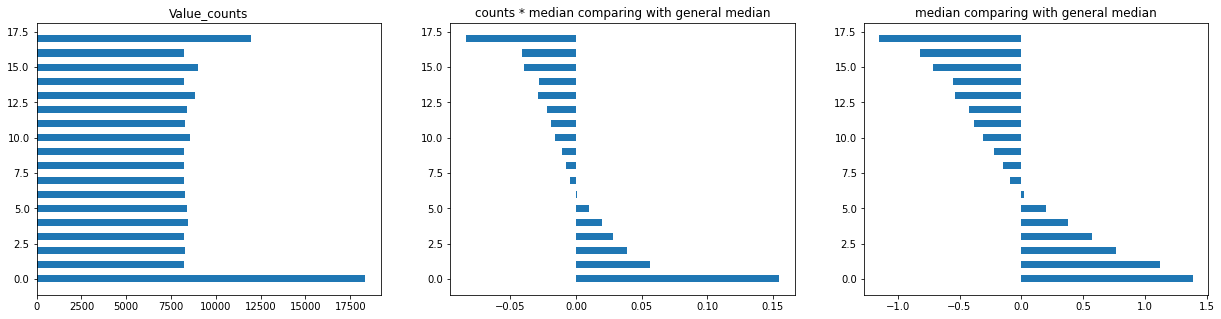

In [152]:
df, bin_col = col_by_bins_fillna_median (df, ['mileage'], 0.05)
print_barhs_reg_median (df, bin_col, 'price')

Судя по графикам, мы верно заменили пустые значения mileage.

Чем выше пробег, тем в среднем автомобиль стоит дешевле.

### description

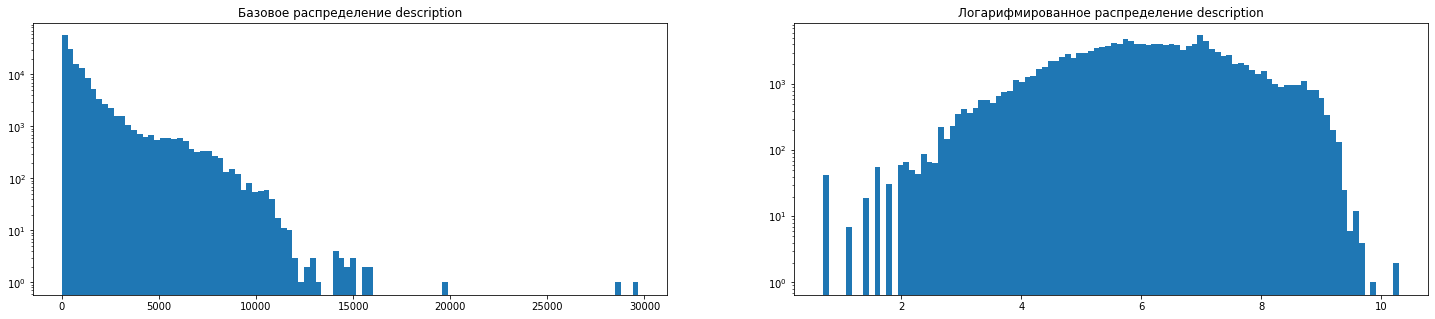

In [153]:
hist_log_compare(df, ['description'])

In [154]:
df['description'] = np.log(df['description']+1)

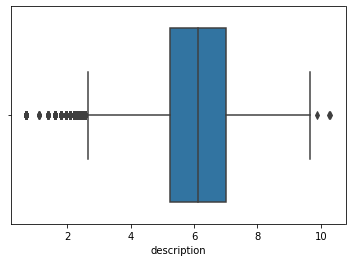

In [155]:
sns.boxplot(data = df , x = 'description')

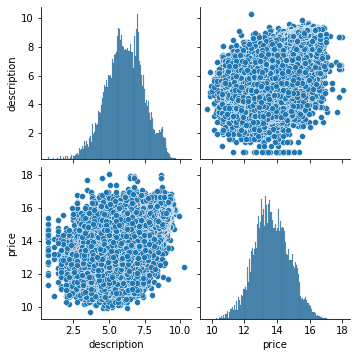

In [156]:
sns.pairplot(df[['description', 'price']])

Разобьём все значения признака на небольшие корзины и посмотрим как влияют на целевую переменную разные участки признака.


description_bins0.05



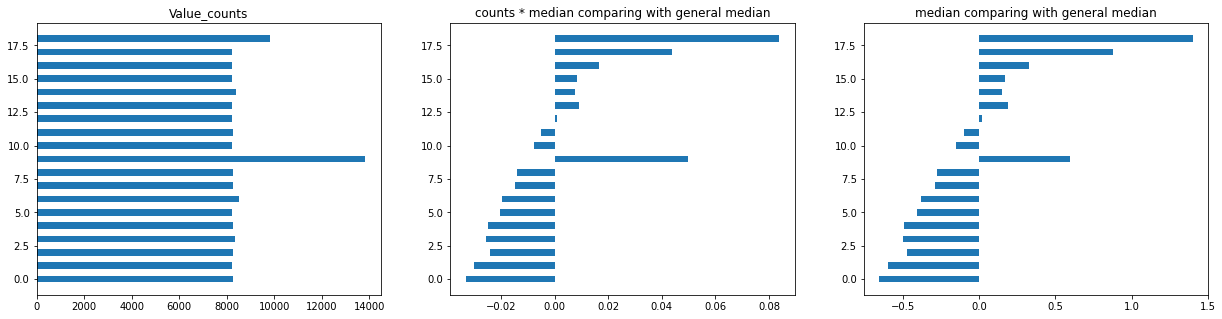

In [157]:
df, bin_col = col_by_bins_fillna_median (df, ['description'], 0.05)
print_barhs_reg_median (df, bin_col, 'price')

Пропуски замененные на медиану, ярко отличаются по влияюнию на цену автомобиля. Стоимость автомобиля соотвествует скорее автомобилям с подробным описанием. Заменим на медиану среди автомобилей с подробным описанием, а также создатим признаки - скупое описание, подробное описание.

In [158]:
df['description'].fillna(df.loc[df['description_bins0.05'].isin(range(15,18)),'description'].median(), inplace = True)


description_bins0.05



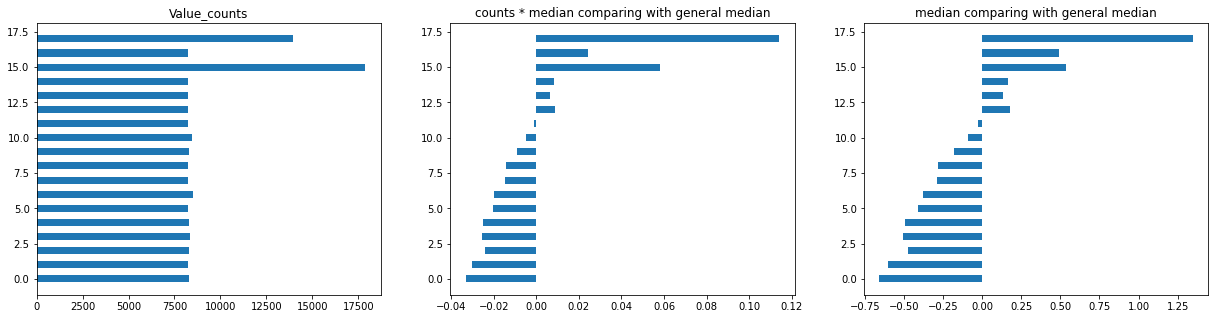

In [159]:
df, bin_col = col_by_bins_fillna_median (df, ['description'], 0.05)
print_barhs_reg_median (df, bin_col, 'price')

In [160]:
df.loc[df['description_bins0.05'].isin(range(16,18)),'detailed_desc'] = 1
new_cat_feats = new_cat_feats + ['detailed_desc']
df.loc[:, new_cat_feats] = df.loc[:, new_cat_feats].apply(lambda x: x.fillna(0))

Предварительный вывод:
Скупое описание соотвествует более дешевым автомобилям. Если описание подробное - автомобиль в среднем дороже.

### Корреляция признаков и замена пропусков

In [161]:
df[num_cols].isna().sum()

engine_volume    3506
engine_power      186
prod_date        3086
mileage             0
description         0
dtype: int64

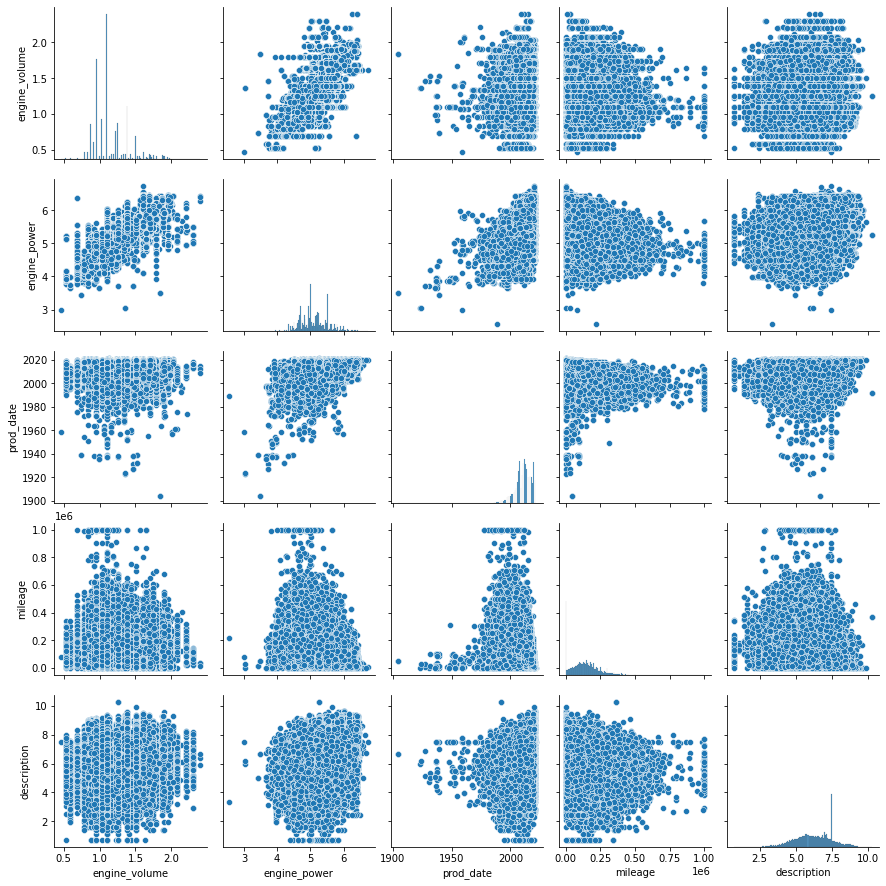

In [162]:
sns.pairplot(df[num_cols])

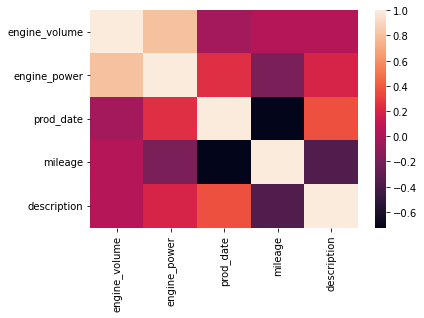

In [163]:
sns.heatmap(df[num_cols].corr())

In [164]:
df[num_cols].corr()

,engine_volume,engine_power,prod_date,mileage,description
engine_volume,1.000000,0.810679,-0.029120,0.047183,0.047298
engine_power,0.810679,1.000000,0.245640,-0.185616,0.192147
prod_date,-0.029120,0.245640,1.000000,-0.726356,0.370812
mileage,0.047183,-0.185616,-0.726356,1.000000,-0.363693
description,0.047298,0.192147,0.370812,-0.363693,1.000000


По матрице и графикам видно, что друг с другом сильно коррелируют признаки:   
engine_volume и engine_power	  
prod_date и model_date  
А также у нас есть признак mileage без пропусков.

Заполним пропуски с использованием других свяазанных признаков и корзин.

In [165]:
pars = {'engine_volume' : 'engine_power_bins0.05', 
        'engine_power' : 'engine_volume_bins0.05', 
        'prod_date' : 'mileage_bins0.05',
        'description' : 'prod_date_bins0.05'} 

In [166]:
for key in pars:
    fillna_by_feat_mode (df, key, pars[key])

### Корреляция c целевым признаком

In [167]:
df[num_cols + ['price']].corr()['price'].sort_values(ascending = False).drop('price')

prod_date        0.755043
engine_power     0.656838
description      0.484007
engine_volume    0.392077
mileage         -0.661683
Name: price, dtype: float64

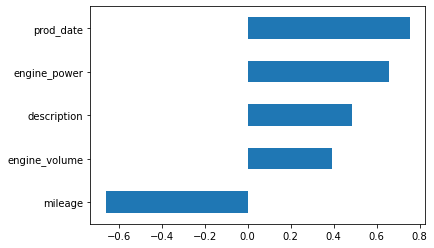

In [168]:
df[num_cols + ['price']].corr()['price'].sort_values().drop('price').plot(kind = 'barh')


engine_volume_bins0.05



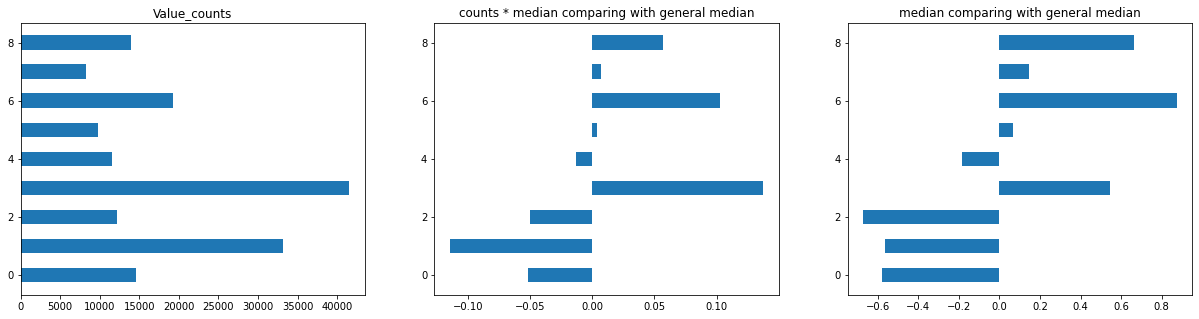



engine_power_bins0.05



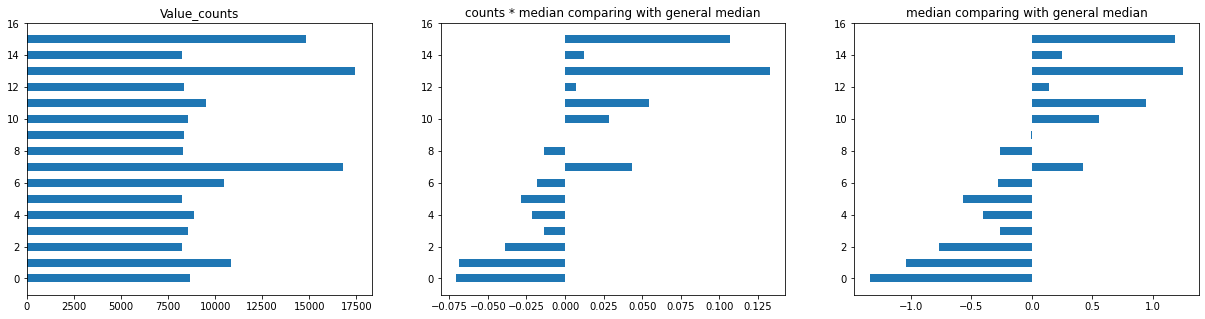



prod_date_bins0.05



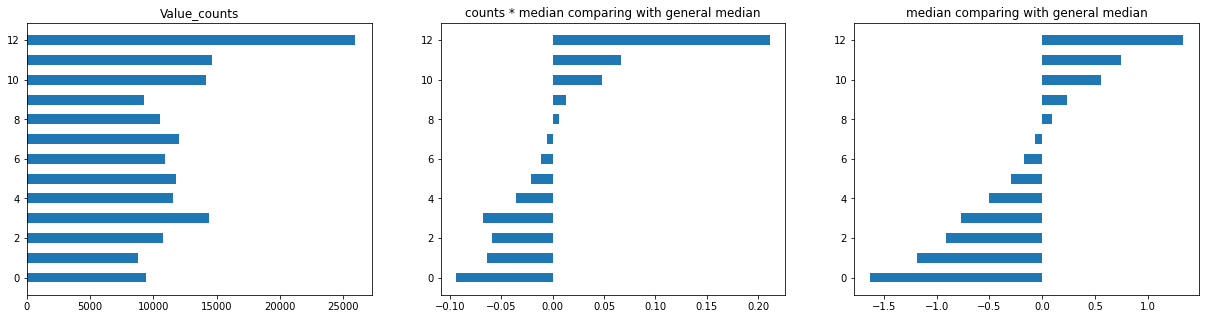



mileage_bins0.05



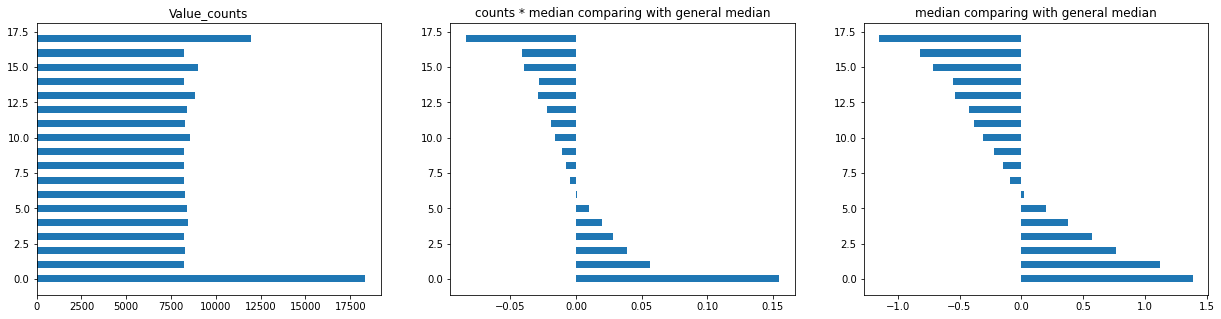



description_bins0.05



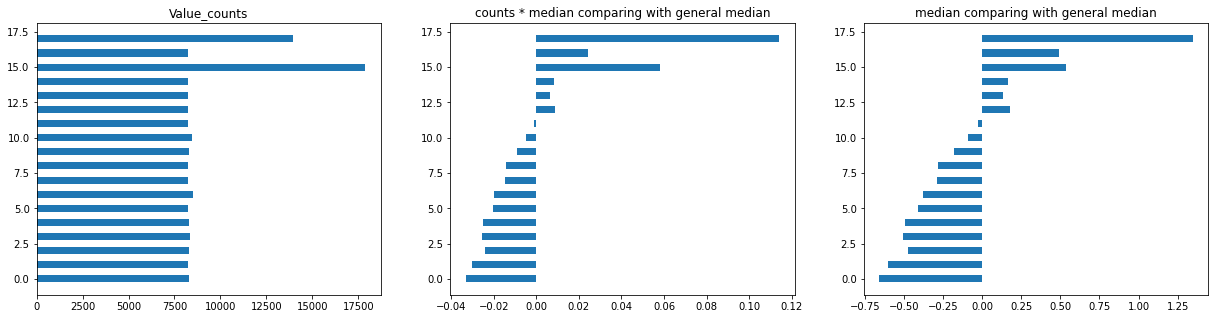

In [169]:
# посмотрим на графики после замены пропусков
df, bins_cols = col_by_bins_fillna_median (df, num_cols, 0.05)
print_barhs_reg_median (df, bins_cols, 'price')

# Feature engeniring

Создадим несколько признаков и преобразуем существующие для дальнейшего обучения.

In [170]:
df['car_age'] = df['parsing_year'] - df['prod_date']
new_num_feats = ['car_age']

In [171]:
df.loc[df['engine_volume_bins0.05'].isin(range(0, 4)), 'volume_bot'] = 1
df.loc[df['engine_power_bins0.05'].isin(range(0, 8)), 'power_bot'] = 1
df.loc[df['engine_power_bins0.05'].isin(range(10, 16)), 'power_top'] = 1
df.loc[df['mileage'] == 0, 'mil_0'] = 1

In [172]:
new_cat_feats = new_cat_feats + ['volume_bot', 'power_bot', 'power_top', 'mil_0']

In [173]:
df.loc[:, new_cat_feats] = df.loc[:, new_cat_feats].apply(lambda x: x.fillna(0))

Упорядочим и закодируем числами наши категориальные значения. Посмотрим на итоговое количественное распределение признаков в датасете и их влияние на 'price'.

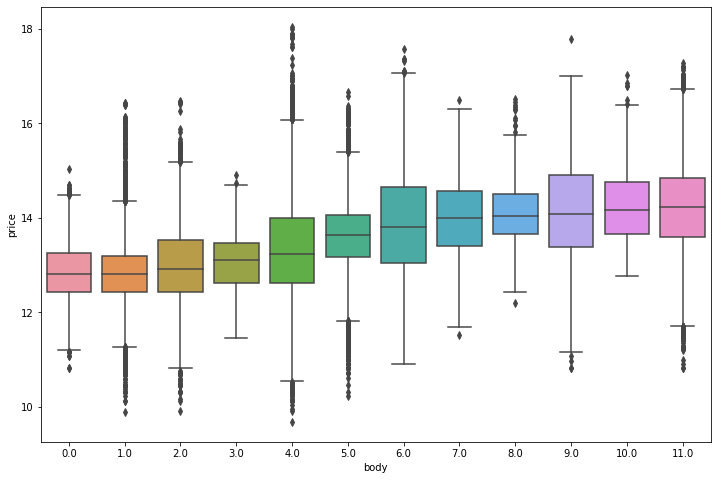

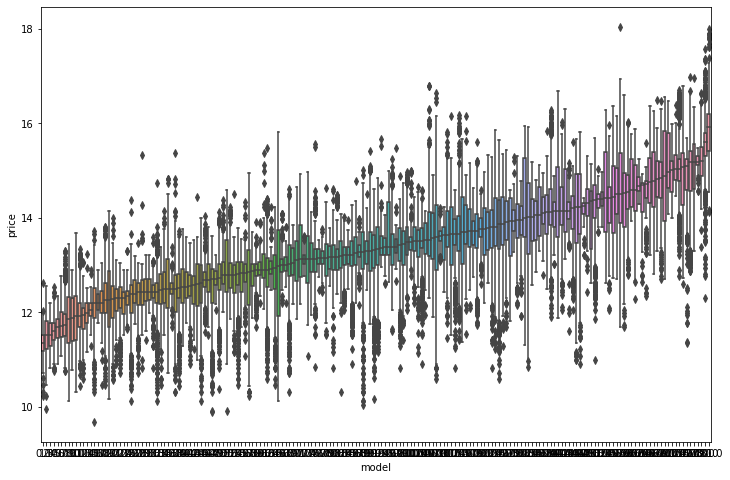

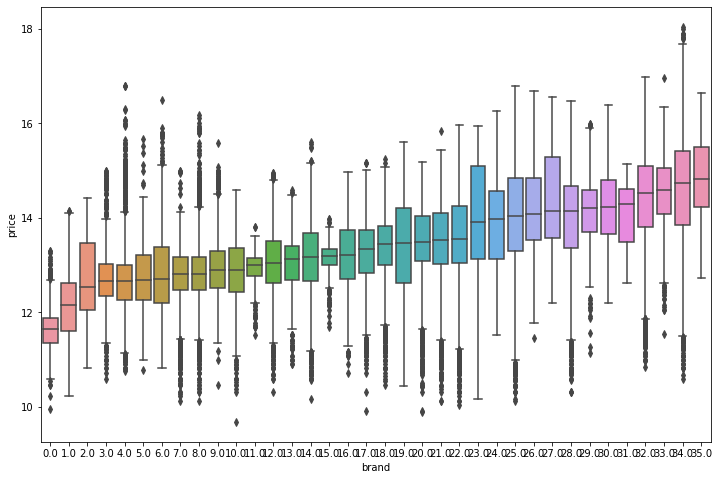

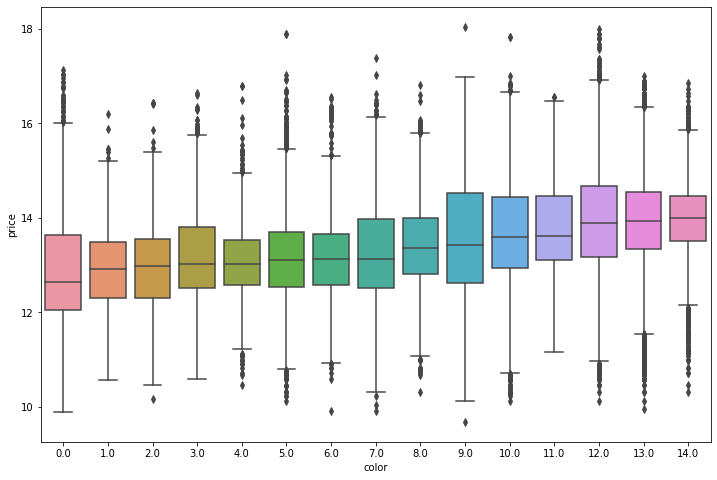

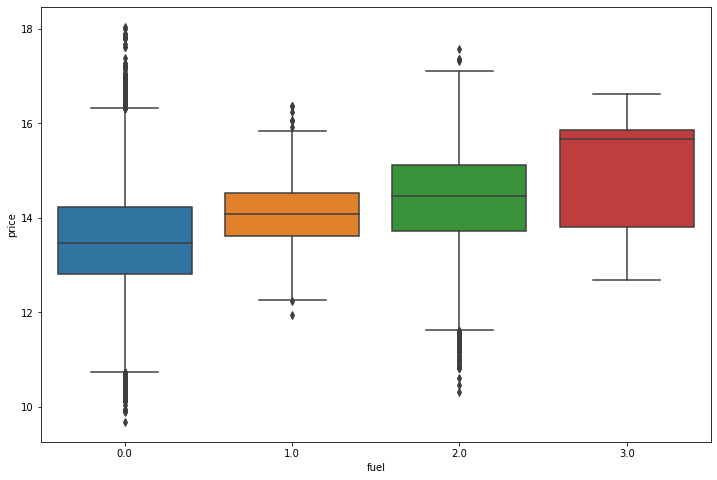

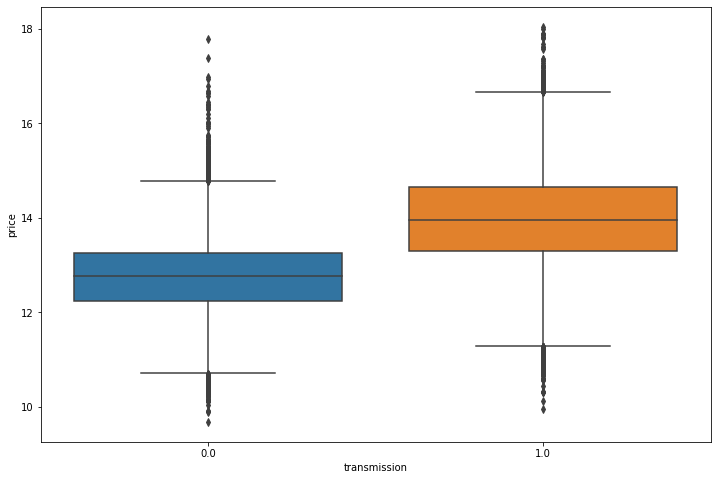

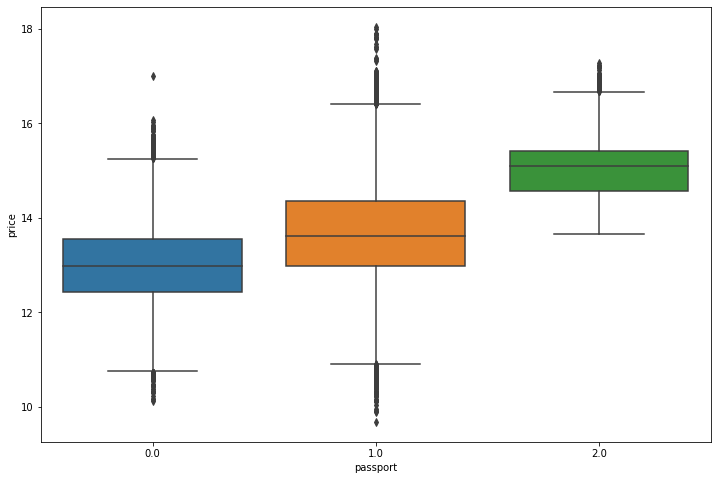

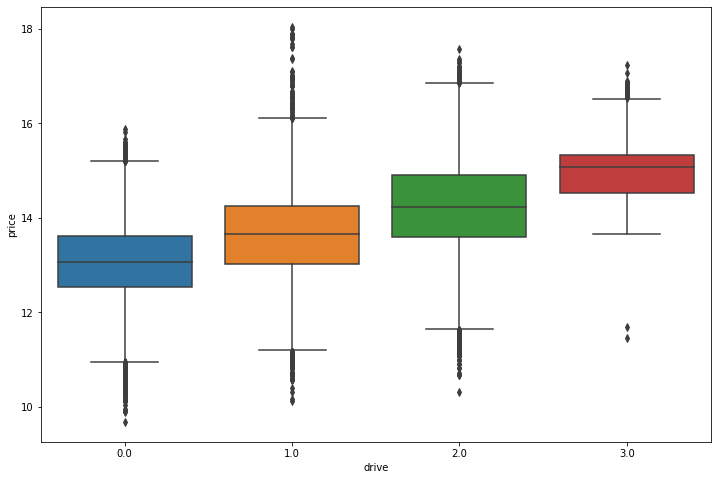

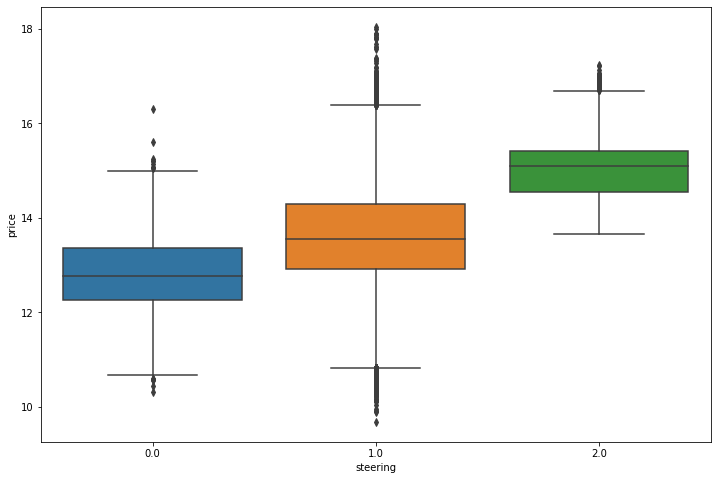

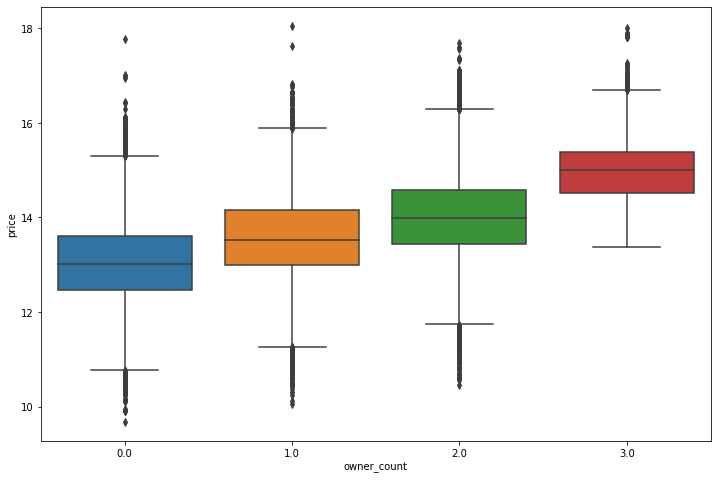

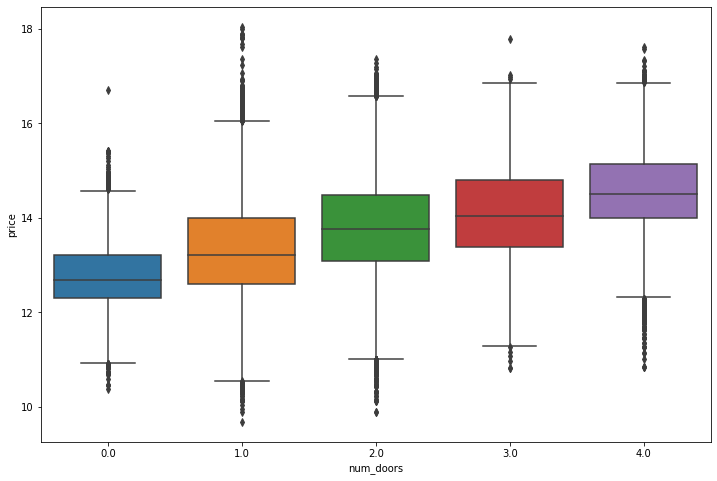

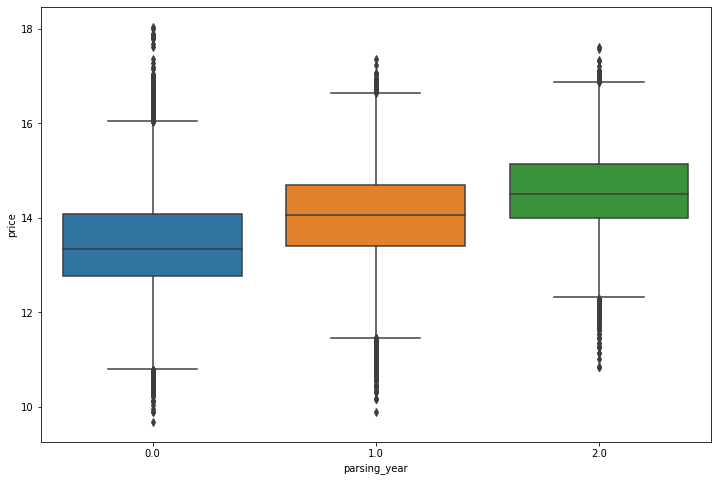

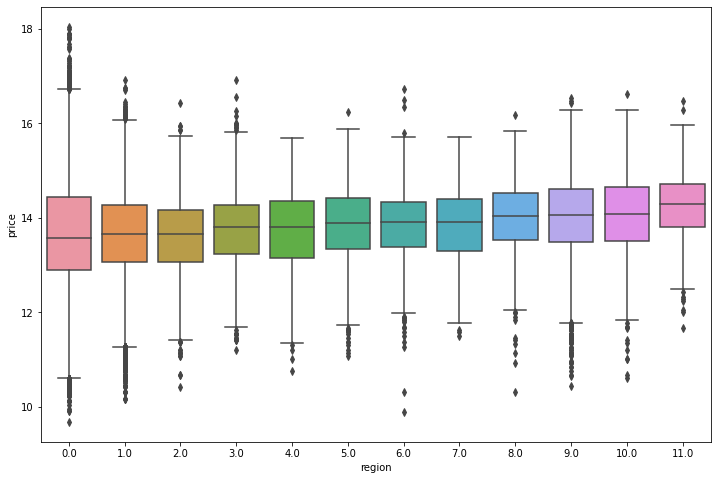

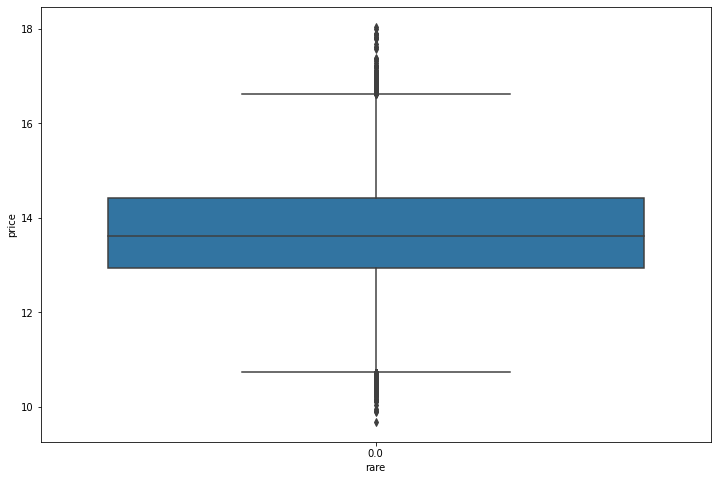

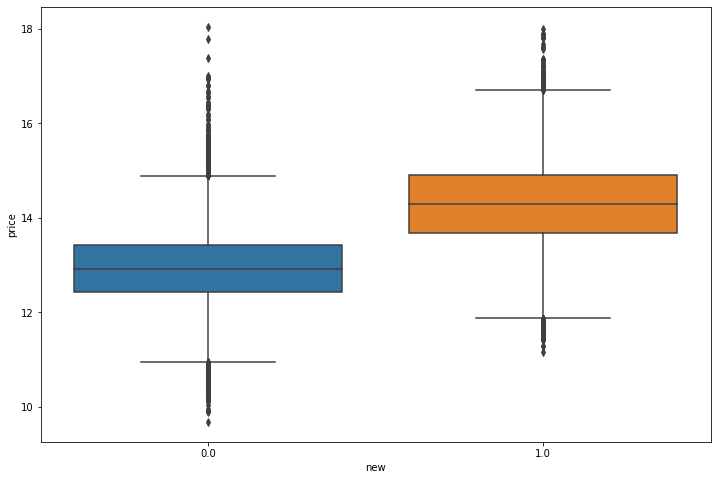

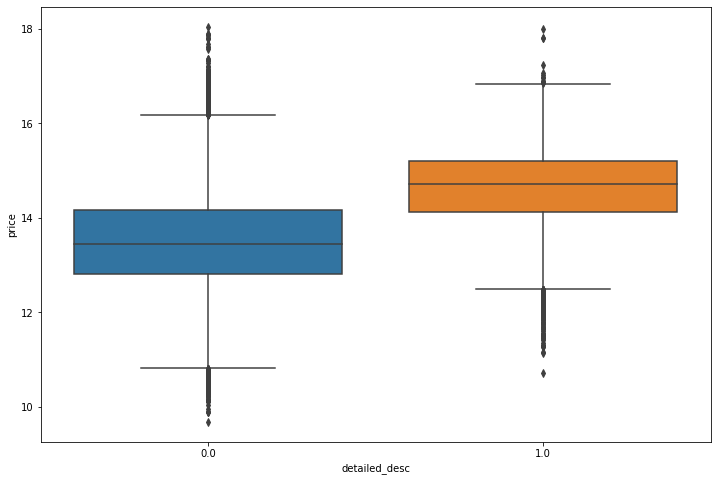

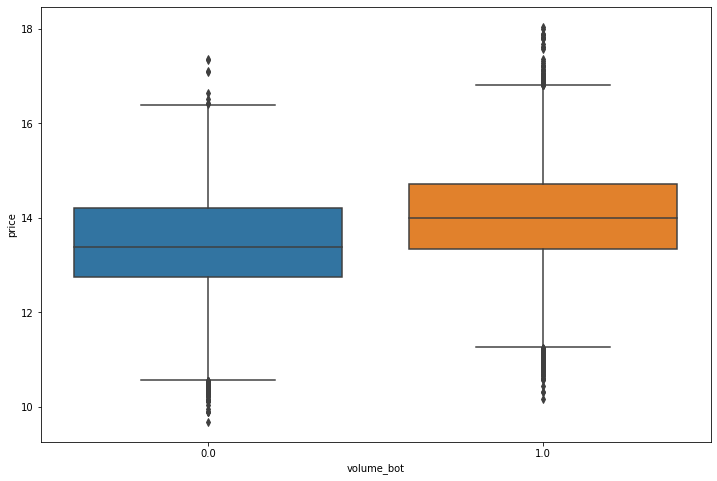

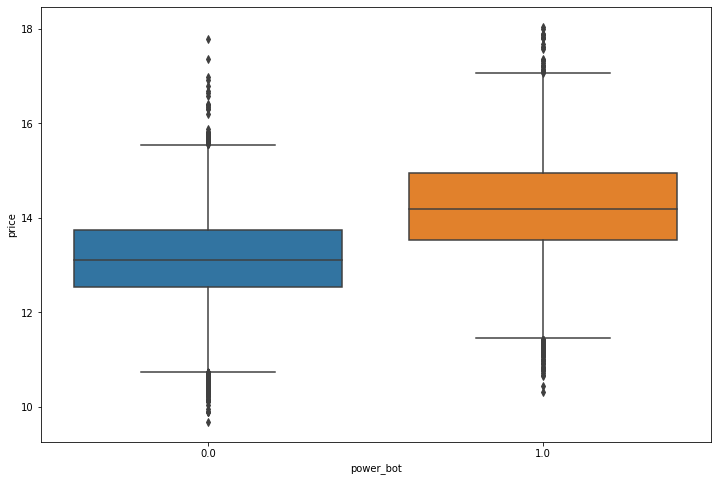

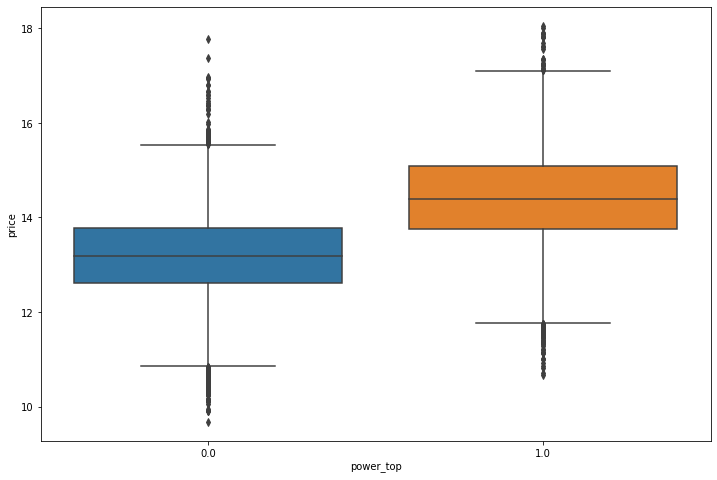

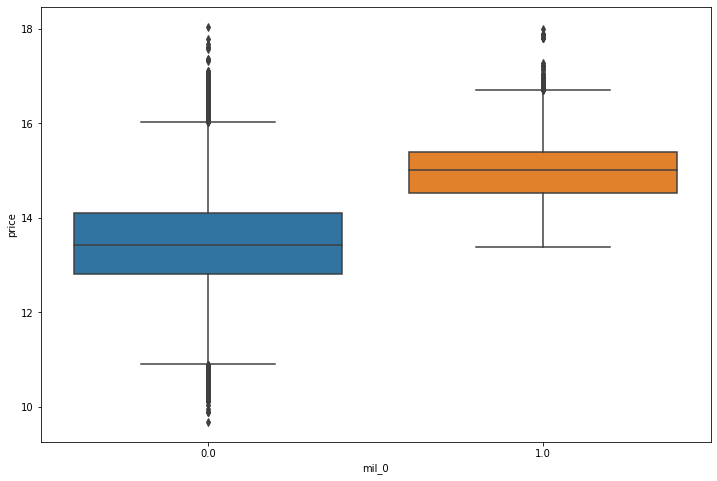

In [174]:
df = order_values_median (df, cat_cols + new_cat_feats, 'price')
boxplots (df, cat_cols + new_cat_feats, 'price')

In [175]:
#создадим дамми-колонки для категориальных признаков, возможно они нам пригодятся
extra_cat_data = pd.get_dummies(df[cat_cols], columns = cat_cols)
dummies_cols = extra_cat_data.columns.to_list()

Посмотрим на новые числовые признаки.


car_age_bins0.05



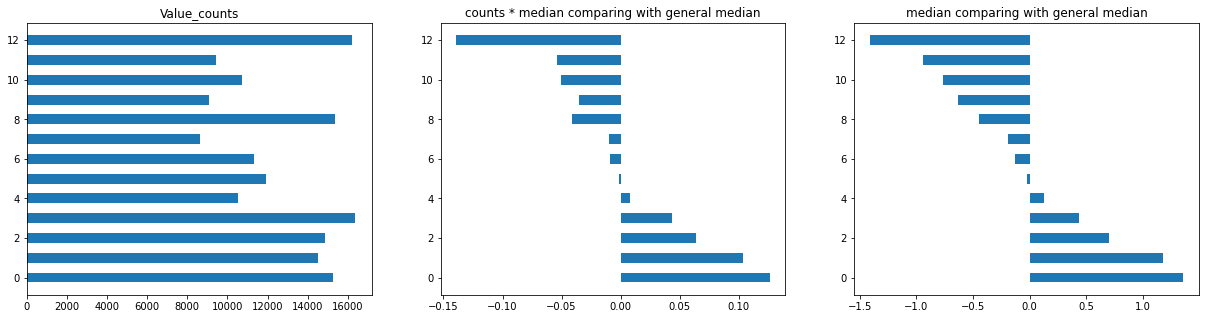

In [176]:
df, bins_cols = col_by_bins_fillna_median (df, new_num_feats, 0.05)
print_barhs_reg_median (df, bins_cols, 'price')

# Feature_selection

## Категории

In [177]:
bin_features_cat = extra_cat_data.columns.to_list()
df[bin_features_cat] = extra_cat_data[bin_features_cat]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


In [178]:
cat_feats = cat_cols + bin_features_cat + new_cat_feats

In [179]:
cfir = cat_features_importants_reg (df, cat_feats, 'price')

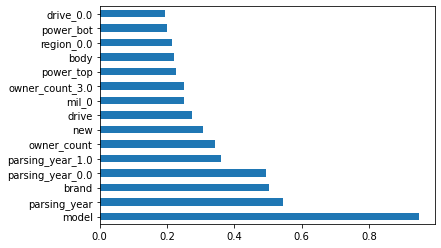

In [180]:
cfir['importance'].head(15).plot(kind = 'barh')

In [181]:
cfir.head(20)

,importance,target_corr,feat_max_corr,feat_name
model,0.946671,0.785951,0.707473,brand
parsing_year,0.544044,0.326565,0.707537,parsing_year_2.0
brand,0.503371,0.566021,0.707473,model
parsing_year_0.0,0.494936,-0.306477,0.612902,region_0.0
parsing_year_1.0,0.361136,0.198239,0.575013,parsing_year
owner_count,0.341945,0.611554,0.698098,mil_0
new,0.308099,0.659264,0.593499,owner_count
drive,0.274226,0.572523,0.797101,drive_2.0
mil_0,0.249873,0.509862,1.000000,owner_count_3.0
owner_count_3.0,0.249873,0.509862,1.000000,owner_count_3.0


In [182]:
cfir[(cfir['feat_max_corr'] > 0.95)]

,importance,target_corr,feat_max_corr,feat_name
mil_0,0.249873,0.509862,1.000000,owner_count_3.0
owner_count_3.0,0.249873,0.509862,1.000000,owner_count_3.0
transmission_1.0,0.154792,0.491048,1.000000,transmission_1.0
transmission,0.154792,0.491048,1.000000,transmission_1.0
parsing_year_2.0,0.117320,0.222022,0.999884,num_doors_4.0
num_doors_4.0,0.117303,0.221883,0.999884,parsing_year_2.0
passport_2.0,0.116527,0.351723,0.978693,steering_2.0
steering_2.0,0.114069,0.344502,0.978693,passport_2.0
fuel,0.081306,0.312817,0.977710,fuel_2.0
fuel_2.0,0.073539,0.303623,0.977710,fuel


In [183]:
# удалим часть сильно скореллированных признаков
to_drop = ['num_doors_4.0', 'fuel_2.0', 'transmission_1.0', 'detailed_desc', 'passport_2.0']
#to_drop = ['num_doors_4.0', 'owner_count_3.0', 'detailed_desc']
df.drop(to_drop, axis = 1, inplace = True)
cat_feats = list(set(cat_feats).difference(set(to_drop)))

In [184]:
# удалим наименее важные признаки
to_drop = cfir[cfir['importance'] < 0.01].index
df.drop(to_drop, axis = 1, inplace = True)
cat_feats = list(set(cat_feats).difference(set(to_drop)))

## Числа

In [185]:
num_feats = num_cols + new_num_feats

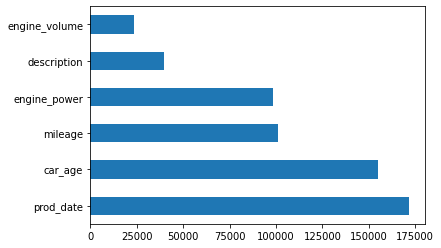

In [186]:
nfir = num_features_importants_reg (df, num_feats,'price')
nfir['importance'].plot(kind = 'barh')

In [187]:
nfir

,importance,target_corr,feat_max_corr,feat_name
prod_date,171791.771028,0.755043,0.419316,description
car_age,155167.316559,-0.738233,0.744859,mileage
mileage,100893.804588,-0.661683,0.744859,car_age
engine_power,98304.633881,0.656838,0.798340,engine_volume
description,39633.285620,0.484007,0.419316,prod_date
engine_volume,23532.460330,0.392077,0.798340,engine_power


# Обучение моделей

Подготовим данные и обучим различные базовые модели. Подберём для них гиперпараметры. На основе базовых моделей стеккинга и voting - модели.

## подготовка к обучению

In [191]:
#подготовим данные для обучения, выделим часть выборки для H-out валидации
df[cat_feats] = df[cat_feats].astype(int)
features = cat_feats + num_feats
X = df.query('test == 0')[features]
X_sub = df.query('test == 1')[features]
y = np.exp(df.loc[df['test'] == 0, 'price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    shuffle=True,
                                                    random_state=42
                                                    ) 

## Model 1: Naive




Эта модель будет предсказывать среднюю цену по дате производства.

In [189]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [190]:
# Находим median по экземплярам 'prod_date' в трейне и размечаем тест
predict = X_test['prod_date'].map(tmp_train.groupby('prod_date')['price'].median())
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 56.59%


## Model 2: CatBoost





У нас в данных много категориальных признаков. Специально для работы с такими данными была создана удобная библиотека CatBoost от Яндекса.

In [ ]:
model = CatBoostRegressor(iterations = 3000,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         cat_features=cat_feats,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         )

In [ ]:
predict_test = np.exp(model.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 12.59%


Leaderboard - 13.68  
Подберём гиперпараметры.

In [ ]:
cbr = CatBoostRegressor(  #iterations = 5000,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=None,
                          verbose = False,
                          #early_stopping_rounds = True,
                          #silent=True,
                         )

iterations = [3000, 5000, 7000]
learning_rate = np.linspace(0.1, 0.3, num = 2)
depth = range(5,9)
l2_leaf_reg = np.linspace(3, 7, num = 3)
grow_policy = ['SymmetricTree', 'Depthwise', 'Lossguide']

random_grid = {'iterations': iterations,
               'learning_rate': learning_rate,
               'depth': depth,
               'l2_leaf_reg': l2_leaf_reg,
               'grow_policy': grow_policy}

randomized_search_result = cbr.randomized_search(random_grid,
                                                   X = X_train,
                                                   y = y_train)


bestTest = 0.1312335575
bestIteration = 2998

0:	loss: 0.1312336	best: 0.1312336 (0)	total: 1m 7s	remaining: 10m 11s

bestTest = 0.1344016424
bestIteration = 2900

1:	loss: 0.1344016	best: 0.1312336 (0)	total: 3m 46s	remaining: 15m 6s

bestTest = 0.1385675042
bestIteration = 2317

2:	loss: 0.1385675	best: 0.1312336 (0)	total: 5m 2s	remaining: 11m 44s

bestTest = 0.1348713929
bestIteration = 4999

3:	loss: 0.1348714	best: 0.1312336 (0)	total: 7m 4s	remaining: 10m 37s

bestTest = 0.1383460865
bestIteration = 1997

4:	loss: 0.1383461	best: 0.1312336 (0)	total: 10m	remaining: 10m

bestTest = 0.1375641479
bestIteration = 1627

5:	loss: 0.1375641	best: 0.1312336 (0)	total: 12m 35s	remaining: 8m 23s

bestTest = 0.13186294
bestIteration = 2723

6:	loss: 0.1318629	best: 0.1312336 (0)	total: 17m 9s	remaining: 7m 21s

bestTest = 0.131377014
bestIteration = 2909

7:	loss: 0.1313770	best: 0.1312336 (0)	total: 21m 25s	remaining: 5m 21s

bestTest = 0.1389022548
bestIteration = 2299

8:	loss: 0.13890

In [ ]:
cbr_params = randomized_search_result['params']
cbr_params

{'depth': 8,
 'grow_policy': 'SymmetricTree',
 'iterations': 3000,
 'l2_leaf_reg': 3.0,
 'learning_rate': 0.1}

In [ ]:
cbr = CatBoostRegressor(  depth = 8,
                          grow_policy = 'SymmetricTree',
                          iterations = 3000, 
                          l2_leaf_reg = 3,
                          learning_rate = 0.1,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=None,
                          verbose = False,
                         )

cbr.fit(X_train, np.log(y_train),
         cat_features=cat_feats,
         eval_set=(X_test, np.log(y_test)),
         use_best_model=True
         )

predict_cbr = np.exp(cbr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_cbr))*100:0.2f}%")

0:	learn: 0.0583227	test: 0.0583330	best: 0.0583330 (0)	total: 821ms	remaining: 41m 1s
1:	learn: 0.0532544	test: 0.0532895	best: 0.0532895 (1)	total: 1.9s	remaining: 47m 30s
2:	learn: 0.0488537	test: 0.0489129	best: 0.0489129 (2)	total: 2.56s	remaining: 42m 33s
3:	learn: 0.0448423	test: 0.0449011	best: 0.0449011 (3)	total: 3.07s	remaining: 38m 19s
4:	learn: 0.0412059	test: 0.0412919	best: 0.0412919 (4)	total: 3.57s	remaining: 35m 36s
5:	learn: 0.0379710	test: 0.0380568	best: 0.0380568 (5)	total: 4.12s	remaining: 34m 13s
6:	learn: 0.0350699	test: 0.0351719	best: 0.0351719 (6)	total: 4.67s	remaining: 33m 15s
7:	learn: 0.0323534	test: 0.0324568	best: 0.0324568 (7)	total: 5.26s	remaining: 32m 47s
8:	learn: 0.0300246	test: 0.0301307	best: 0.0301307 (8)	total: 5.75s	remaining: 31m 49s
9:	learn: 0.0279679	test: 0.0280814	best: 0.0280814 (9)	total: 6.36s	remaining: 31m 41s
10:	learn: 0.0262112	test: 0.0263327	best: 0.0263327 (10)	total: 6.89s	remaining: 31m 13s
11:	learn: 0.0246061	test: 0.024

Leaderboard - 12.83

## Model 3: RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(random_state = 42)
rfr.fit(X_train, np.log(y_train))
predict_rfr = np.exp(rfr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_rfr))*100:0.2f}%")

Точность модели по метрике MAPE: 12.45%


In [ ]:
predict_submission = np.exp(rfr.predict(X_sub))

Leaderboard - 13.2  
Подберём гиперпараметры  

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 900, num = 3)]
max_features = ['sqrt', 1/3]
max_depth = [int(x) for x in np.linspace(10, 20, num = 2)]
max_depth.append(None)
min_samples_split = [2, 5]
min_samples_leaf = [1, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rfr = RandomForestRegressor(random_state=42)
rfr_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid, n_iter=10, 
                               cv=2, verbose=2, random_state=42, n_jobs=-1)

In [ ]:
rfr_random.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, None],
                                        'max_features': ['sqrt',
                                                         0.3333333333333333],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 500, 900]},
                   random_state=42, verbose=2)

In [ ]:
rfr_random.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 0.3333333333333333,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 900}

In [ ]:
rfr_best = RandomForestRegressor(random_state = 42, 
                                 bootstrap = True,
                                  max_depth = None,
                                  max_features = 1/3,
                                  min_samples_leaf = 1,
                                  min_samples_split = 5,
                                  n_estimators = 900)

In [ ]:
rfr_best.fit(X_train, np.log(y_train))
predict_rfr_best = np.exp(rfr_best.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_rfr_best))*100:0.2f}%")

Leaderboard - 11.9

## Model 4: ExtraTreesRegressor

In [ ]:
etr = ExtraTreesRegressor(random_state = 42)
etr.fit(X_train, np.log(y_train))
predict_etr = np.exp(etr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_etr))*100:0.2f}%")

Точность модели по метрике MAPE: 12.80%


Leaderboard - 12.9  
Подбрерём гиперпараметры

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 900, num = 3)]
max_features = ['sqrt', 1/3]
max_depth = [int(x) for x in np.linspace(10, 20, num = 2)]
max_depth.append(None)
min_samples_split = [2, 5]
min_samples_leaf = [1, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
etr = ExtraTreesRegressor(random_state = 42)
etr_random = RandomizedSearchCV(estimator=etr, param_distributions=random_grid, n_iter=10, 
                               cv=2, verbose=2, random_state=42, n_jobs=-1)

In [ ]:
etr_random.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=2, estimator=ExtraTreesRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, None],
                                        'max_features': ['sqrt',
                                                         0.3333333333333333],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 500, 900]},
                   random_state=42, verbose=2)

In [ ]:
etr_random.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 0.3333333333333333,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 900}

In [ ]:
etr_best = ExtraTreesRegressor(random_state = 42, 
                                 bootstrap = True,
                                  max_depth = None,
                                  max_features = 1/3,
                                  min_samples_leaf = 1,
                                  min_samples_split = 5,
                                  n_estimators = 900)

In [ ]:
etr_best.fit(X_train, np.log(y_train))
predict_etr_best = np.exp(etr_best.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_etr_best))*100:0.2f}%")

Точность модели по метрике MAPE: 12.43%


Leaderboard - 12.3

## Model 5: LightGBM

In [ ]:
lgbr = lgb.LGBMRegressor(objective="regression", 
                        n_estimators=10000, 
                        metric = "MAPE",
                        bagging_fraction = 0.5,
                        learning_rates = 0.1)

In [ ]:
lgbr.fit(X_train, np.log(y_train), eval_metric="MAPE") #eval_set=[(X_test, np.log(y_test)),]

predict_lgb = np.exp(lgbr.predict(X_test))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_lgb))*100:0.2f}%")

Точность модели по метрике MAPE: 12.40%


## Model 6: Voting

In [ ]:
regr = LinearRegression()
vr = VotingRegressor([     ('lgbr', lgbr), 
                           ('rfr_best', rfr_best), 
                           ('etr_best', etr_best)
                           ])
vr.fit(X_train, np.log(y_train)) 
predict_vr = np.exp(vr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_vr))*100:0.2f}%")

Точность модели по метрике MAPE: 11.89%


Leaderboard - 11.5

## Model 7: Stacking

In [ ]:
estimators = [#('cbr', cbr), 
               ('lgbr', lgbr),  
               ('rfr_best', rfr_best), 
               ('etr_best', etr_best)
              ]
stack_reg = StackingRegressor(estimators = estimators, final_estimator = regr)

In [ ]:
stack_reg.fit(X_train, np.log(y_train))

StackingRegressor(estimators=[('lgbr',
                               LGBMRegressor(bagging_fraction=0.5,
                                             learning_rates=0.1, metric='MAPE',
                                             n_estimators=10000,
                                             objective='regression')),
                              ('rfr_best',
                               RandomForestRegressor(max_features=0.3333333333333333,
                                                     min_samples_split=5,
                                                     n_estimators=900,
                                                     random_state=42)),
                              ('etr_best',
                               ExtraTreesRegressor(bootstrap=True,
                                                   max_features=0.3333333333333333,
                                                   min_samples_split=5,
                                                   n_estimators=90

In [ ]:
predict_stack = np.exp(stack_reg.predict(X_test))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_stack))*100:0.2f}%")  

Точность модели по метрике MAPE: 11.87%


Leaderboard - 11.4

In [ ]:
predict_submission = np.exp(stack_reg.predict(X_sub))
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.383943e+05
1,1100549428,9.546930e+05
2,1100658222,8.757405e+05
3,1100937408,7.011678e+05
4,1101037972,6.886962e+05
5,1100912634,7.465606e+05
6,1101228730,6.056546e+05
7,1100165896,3.860418e+05
8,1100768262,1.895274e+06
9,1101218501,8.045807e+05


# Выводы

1) Сфорировали обучающуюу выборку: спарсили свежие данные в январе 2022года, а также взяли данные за 2021 год у других студентов.  
2) Почистили и преобразовали данные.  
3) Провели разведовательный анализ, почистили выбросы.  
4) Сформировали новые признаки  
5) Провели отбор признаков. Самые значимые признаки:  
- бренд и модель автомобиля
- количество владельцев
- пробег автомобиля 
- год производства автомобиля
- двигатель (комбинация мощности и объёма двигателя)
  
6) Обучили базовые модели, подобрали гиперпараметры, обучили мета-модели  
7) Оценили качество моделей. Удалось существенно улучшить результат базового решения.   
Лучше всего показал себя стеккинг на основе трёх моделей: RandomForest, ExtraTrees, LightGBM. Результат итоговой модели - 11.4% на лидерборде. 
